# Knowledge Discovery report

The purpose of this project is to extract useful, valid, novel and understandable patterns from the 1994 Census income, available at [ML repository](https://archive.ics.uci.edu/dataset/2/adult). The goals is to uncover insights to determine the factors influencing whether a person earns more than $50K a year or not.

## Abstract

This project leverages Python as the primary software tool for pre-processing, exploring, and mining the 1994 Census Income dataset. Python was chosen for its extensive libraries, which support efficient data processing and advanced machine learning. The key objective is to classify income levels (<=50K and >50K) using Decision Trees (DT), Random Forest (RF), and Logistic Regression algorithms (LR).
A significant focus of the project is the extraction of decision rules from DT and RF models. These rules provide transparent, interpretable insights into the factors influencing income levels. While Decision Trees offer straightforward decision paths, Random Forest, with its ensemble of trees, not only improves predictive accuracy but also aggregates decision rules, ensuring robust knowledge extraction. 


## Import required libraries

In [2]:
import numpy as np 
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import string
import seaborn as sns
import scipy.stats as stats
import networkx as nx
import math
import plotly.express as px
import shap


from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV,KFold
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics 
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score, classification_report, ConfusionMatrixDisplay, make_scorer
from scipy.stats import shapiro, kstest, anderson, skew, kurtosis, pointbiserialr, chi2_contingency
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE  
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.multiclass import OneVsRestClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_selection import RFE
from collections import Counter, defaultdict
from treeinterpreter import treeinterpreter as ti
from tqdm.autonotebook import tqdm

## 1. Pre-processing data

### Loading dataset

In [3]:
df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


The dataset contained null values across both numerical and categorical features. The categorical data included both nominal and ordinal variables. Additionally, the dataset had redundant columns that required removal or consolidation.

In [4]:
#General info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Some variables are of type "object." Most supervised learning algorithms require numerical inputs. The numerical features should be scaled and nominal could be handle with label encoding (often used for ordinal categorical variables) or encodes using one-hot encoding(often used when there is no oder between categories) to apply data mining algorithms. These preprocessing task needs to be done before using the dataset for model training.

### Checking for missing data, incorrect values, duplicated values, blanks

In [5]:
#Check for missing data
df.isna().sum() #checking for missing values

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [6]:
# Check for blank (empty) values
blanks = (df == '').any().any()
blanks

False

In [7]:
# Check for NA or NaN values
na_values = df.isna().any().any()
na_values

False

### NaN missing data

In [8]:
# Check for '?' values
question_marks = (df == '?').any().any()
question_marks

True

The dataset included both numerical and categorical values, with the categorical data encompassing both nominal and ordinal types. Additionally, the dataset contained redundant columns and some values represented by question marks (?)

In [9]:
#Check how many observations with question marks ?
# The first step is to replace '>' with NaN so then it could be counting
df[df=='?']=np.nan

#Second step is to count the number of NaN
Numques = df.isna().sum().sum()
print(f'Number of obs with "?"is: {Numques }')

# Count the number of rows with at least one NaN
num_rows_with_nan = df.isna().any(axis=1).sum()
print(f'Number of rows with at least one NaN: {num_rows_with_nan}')
      

Number of obs with "?"is: 4262
Number of rows with at least one NaN: 2399


In [10]:
# Identify the locations of NaN values
Numques_locations = df[df.isna().any(axis=1)]
Numques_locations.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,NaN,>50K
14,51,NaN,172175,Doctorate,16,Never-married,NaN,Not-in-family,White,Male,0,2824,40,United-States,>50K
18,22,Private,119592,Assoc-acdm,12,Never-married,Handlers-cleaners,Not-in-family,Black,Male,0,2824,40,NaN,>50K


In [11]:
#checking data distribution of categories with ?
NaN_data = df.isna().sum()
print(NaN_data[NaN_data > 0])

workclass         1836
occupation        1843
native.country     583
dtype: int64


The NaN observations are not related to the target variable. the majoroty of NaN are shown in the workclass feature followed by occupation and native.country

In [12]:
##  Calculate proportion of NaN out of the total dataset
missing_count = df.isnull().sum()
value_count = df.isnull().count()
missing_percentage = round(missing_count / value_count * 100, 2)
missing_df = pd.DataFrame({"count": missing_count, "percentage": missing_percentage})
missing_df

,count,percentage
age,0,0.00
workclass,1836,5.64
fnlwgt,0,0.00
education,0,0.00
education.num,0,0.00
marital.status,0,0.00
occupation,1843,5.66
relationship,0,0.00
race,0,0.00
sex,0,0.00


4,262 total of observations with Nan represent around 13.1 % of total dataset. Before removing these instances, it is important to evaluate thhe impact of removing missing values in the analaysis. Tehre are two options dropping the NaN or replace it by using imputation methods. An impact analysis is underatken to assess effects of droppping or including NaN in the analysis

Missing data causes two main problems: analyses become inconsistent because results are based on different parts of the dataset and missing data is often not random, so the sample may not represent the entire population accurately, causing biased estimates of population characteristics

### Checking distribution of features including and excluding NaN

In [13]:
## Check how target class is distributed when dropping NaN 
dropp_NaN_income_less_50K = Numques_locations[Numques_locations['income'] == '<=50K']
dropp_NaN_income_over_50K = Numques_locations[Numques_locations['income'] == '>50K']


## Check how target class is distributed when including NaN 
include_NaN_income_less_50K = df[df['income'] == '<=50K']
include_NaN_income_over_50K = df[df['income'] == '>50K']

Distribution Comparison (in %):
        Include_NaN   Drop_NaN
income                        
<=50K     75.919044  86.119216
>50K      24.080956  13.880784


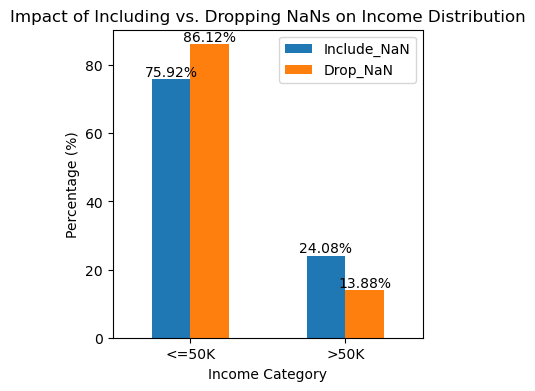

In [14]:
# Calculate distribution when including NaNs
distribution_include_nan = pd.concat([include_NaN_income_less_50K, include_NaN_income_over_50K])['income'].value_counts(normalize=True) * 100

# Calculate distribution when dropping NaNs
distribution_drop_nan = pd.concat([dropp_NaN_income_less_50K, dropp_NaN_income_over_50K])['income'].value_counts(normalize=True) * 100

# Combine the distributions into a single DataFrame for comparison
distribution_comparison = pd.DataFrame({
    'Include_NaN': distribution_include_nan,
    'Drop_NaN': distribution_drop_nan
}).fillna(0)  # Fill NaN with 0 if any class is missing in the distribution

print("Distribution Comparison (in %):")
print(distribution_comparison)

# Plot the distributions
ax1=distribution_comparison.plot(kind='bar', figsize=(4, 4))

# Add labels on top of the bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f%%', label_type='edge')


plt.title('Impact of Including vs. Dropping NaNs on Income Distribution')
plt.ylabel('Percentage (%)')
plt.xlabel('Income Category')
plt.xticks(rotation=0)
plt.show()

Income <=50K: The proportion of this class increases significantly when NaN values are dropped (from 75.92% to 86.12%)
Income >50K: The proportion of this class decreases when NaN values are dropped (from 24.08% to 13.88%)

This suggests that the rows with missing data are more likely associated with the >50K income class. By dropping these rows, the dataset is likely to be under-representing the >50K class in your which can lead to biased analysis or predictions if the imbalance is not addressed

In [15]:
# Function to assess occurrences and NaN counts for cateregorical features
def assess_category(df, category):
    # Count total occurrences, including NaNs
    total_counts = df[category].value_counts(dropna=False)
    
    # Count NaN occurrences
    nan_counts = df[category].isna().groupby(df[category]).sum()

    # Combine results into a single DataFrame
    summary_df = pd.DataFrame({
        'Total_Count': total_counts,
        'NaN_Count': nan_counts.reindex(total_counts.index, fill_value=0),
        'Non_NaN_Count': total_counts - nan_counts.reindex(total_counts.index, fill_value=0)
    }).reset_index()

    # Rename the columns for clarity
    summary_df.columns = [category, 'Total_Count', 'NaN_Count', 'Non_NaN_Count']

    # Print the summary DataFrame
    print(f"Summary for {category}:\n")
    print(summary_df)
    print("\n" + "-"*50 + "\n")

# List of categories to assess
categories = ['workclass', 'occupation', 'native.country']

# Loop through each category and apply the function
for category in categories:
    assess_category(df, category)

Summary for workclass:

          workclass  Total_Count  NaN_Count  Non_NaN_Count
0           Private        22696          0          22696
1  Self-emp-not-inc         2541          0           2541
2         Local-gov         2093          0           2093
3               NaN         1836          0           1836
4         State-gov         1298          0           1298
5      Self-emp-inc         1116          0           1116
6       Federal-gov          960          0            960
7       Without-pay           14          0             14
8      Never-worked            7          0              7

--------------------------------------------------

Summary for occupation:

           occupation  Total_Count  NaN_Count  Non_NaN_Count
0      Prof-specialty         4140          0           4140
1        Craft-repair         4099          0           4099
2     Exec-managerial         4066          0           4066
3        Adm-clerical         3770          0           3770
4  

### Data imbalance target class income

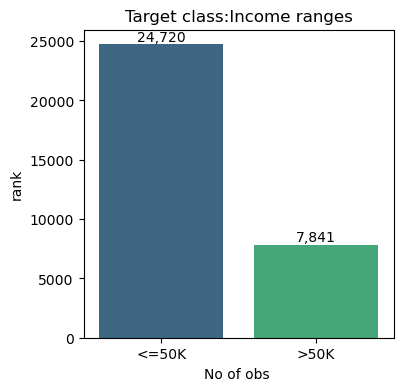

In [16]:
# Check class distribution income in a plot bar chart

# set figure size
plt.figure(figsize=(4, 4))

ax2 = sns.countplot(data=df, x='income', hue='income', palette="viridis", dodge=False)

# Add labels to the top of each bar
for container in ax2.containers:
    ax2.bar_label(container, fmt='{:,.0f}')

plt.title('Target class:Income ranges')
plt.xlabel('No of obs ')
plt.ylabel('rank');

In [17]:
# summarize the class distribution
target_class = df['income']
counter = Counter(target_class)

for k, v in counter.items():
    per = v / len(target_class) * 100
    print(f'Class={k}, Count={v}, Percentage={per:.3f}%')

Class=<=50K, Count=24720, Percentage=75.919%
Class=>50K, Count=7841, Percentage=24.081%


The original Census income data contains class imbalance with 75.91% of people earning <=50K. This can lead to an irregular distribution, where some quality scores are more frequent than others, and there might be gaps or uneven spacing between the scores. The aggregation of wine quality into broader categories changes the data from irregular to regular by simplifying the distribution, reducing noise, and balancing the classes. This transformation makes the data easier to work with and can lead to better model performance by focusing on the most important distinctions in the dataset

In [18]:
#categoricals
categorical_cols = df.columns[df.dtypes==object].tolist()
categorical_cols

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country',
 'income']

In [19]:
#numerical
numerical_cols = df.columns[df.dtypes != object].tolist()
numerical_cols

['age',
 'fnlwgt',
 'education.num',
 'capital.gain',
 'capital.loss',
 'hours.per.week']

### Correlation among numerical features with target variable: income

In [20]:
# List of numerical columns to analyze
numerical_columns = ['age', 'fnlwgt', 'education.num', 'capital.gain', 
                     'capital.loss', 'hours.per.week']

# Convert 'income' to a binary variable (if not already done)
df['income_class'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

# Loop through each numerical variable and calculate Point-biserial correlation
for column in numerical_columns:
    correlation, p_value = pointbiserialr(df['income_class'], df[column])
    
    # Print the results
    print(f'Correlation between income_class and {column}: {correlation}, p-value: {p_value}')

Correlation between income_class and age: 0.2340371026488576, p-value: 0.0
Correlation between income_class and fnlwgt: -0.009462557247529214, p-value: 0.08773666108063798
Correlation between income_class and education.num: 0.3351539526909421, p-value: 0.0
Correlation between income_class and capital.gain: 0.22332881819538278, p-value: 0.0
Correlation between income_class and capital.loss: 0.15052631177035375, p-value: 2.6865471890515574e-164
Correlation between income_class and hours.per.week: 0.22968906567081038, p-value: 0.0


Point-biserial correlation is commonly used when you want to measure the correlation between a binary variable (like income) and continuous variables (like age, capital.gain, etc.). This is a special case of the Pearson correlation where one variable is binary

Significant Correlations: Age, education level, capital gain, capital loss, and hours per week all show significant correlations with income, though the strength of these relationships varies (from weak to moderate)

Non-Significant Correlation: The final weight (fnlwgt) does not have a significant relationship with income, meaning it is not a useful predictor in this context

### Correlation among categorical features with target variable: income

In [21]:
#check corretaional between categorical variables and income
# List of categorical columns to analyze
categorical_columns = ['workclass', 'education', 'marital.status', 'occupation', 
                       'relationship', 'race', 'sex', 'native.country']

# Loop through each categorical variable and calculate Chi-square statistic
for column in categorical_columns:
    # Create a contingency table
    contingency_table = pd.crosstab(df['income'], df[column])
    
    # Perform Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Print the results
    print(f"Chi-square statistic for {column}: {chi2}, p-value: {p}")

Chi-square statistic for workclass: 827.7183593884149, p-value: 1.9338476684848218e-174
Chi-square statistic for education: 4429.653302288619, p-value: 0.0
Chi-square statistic for marital.status: 6517.741653663021, p-value: 0.0
Chi-square statistic for occupation: 3744.8987583977073, p-value: 0.0
Chi-square statistic for relationship: 6699.076896858851, p-value: 0.0
Chi-square statistic for race: 330.9204310085741, p-value: 2.305960610160958e-70
Chi-square statistic for sex: 1517.813409134445, p-value: 0.0
Chi-square statistic for native.country: 317.08766300681896, p-value: 8.280446050912633e-45


Chi-Square Test is used to assesses whether there's a significant association between two categorical variables
The large Chi-square statistic and the very small p-value (essentially zero) indicate a strong association between income and education

Null Hypothesis (H₀): The distribution of categories in the data is the same as the expected distribution. In simpler terms, this means that any differences between the observed and expected counts are due to random chance, not a systematic effect

The Chi-Square test results show that the distributions of occupation, workclass, and native.country in the Census income are significantly different from the expeted distribution if there were no specific pattern (e.g., if categories were evenly distributed). The p-value of 0.0 means these differences are highly statistically significant and so there is difference between the observed and expented frequency

Each of these categorical variables workclass, education, marital.status, occupation, relationship, race, sex, and native.country are strongly related to the income level (<=50K vs. >50K). This suggests that differences in these categories are associated with differences in income levels


### Feature summary distributions

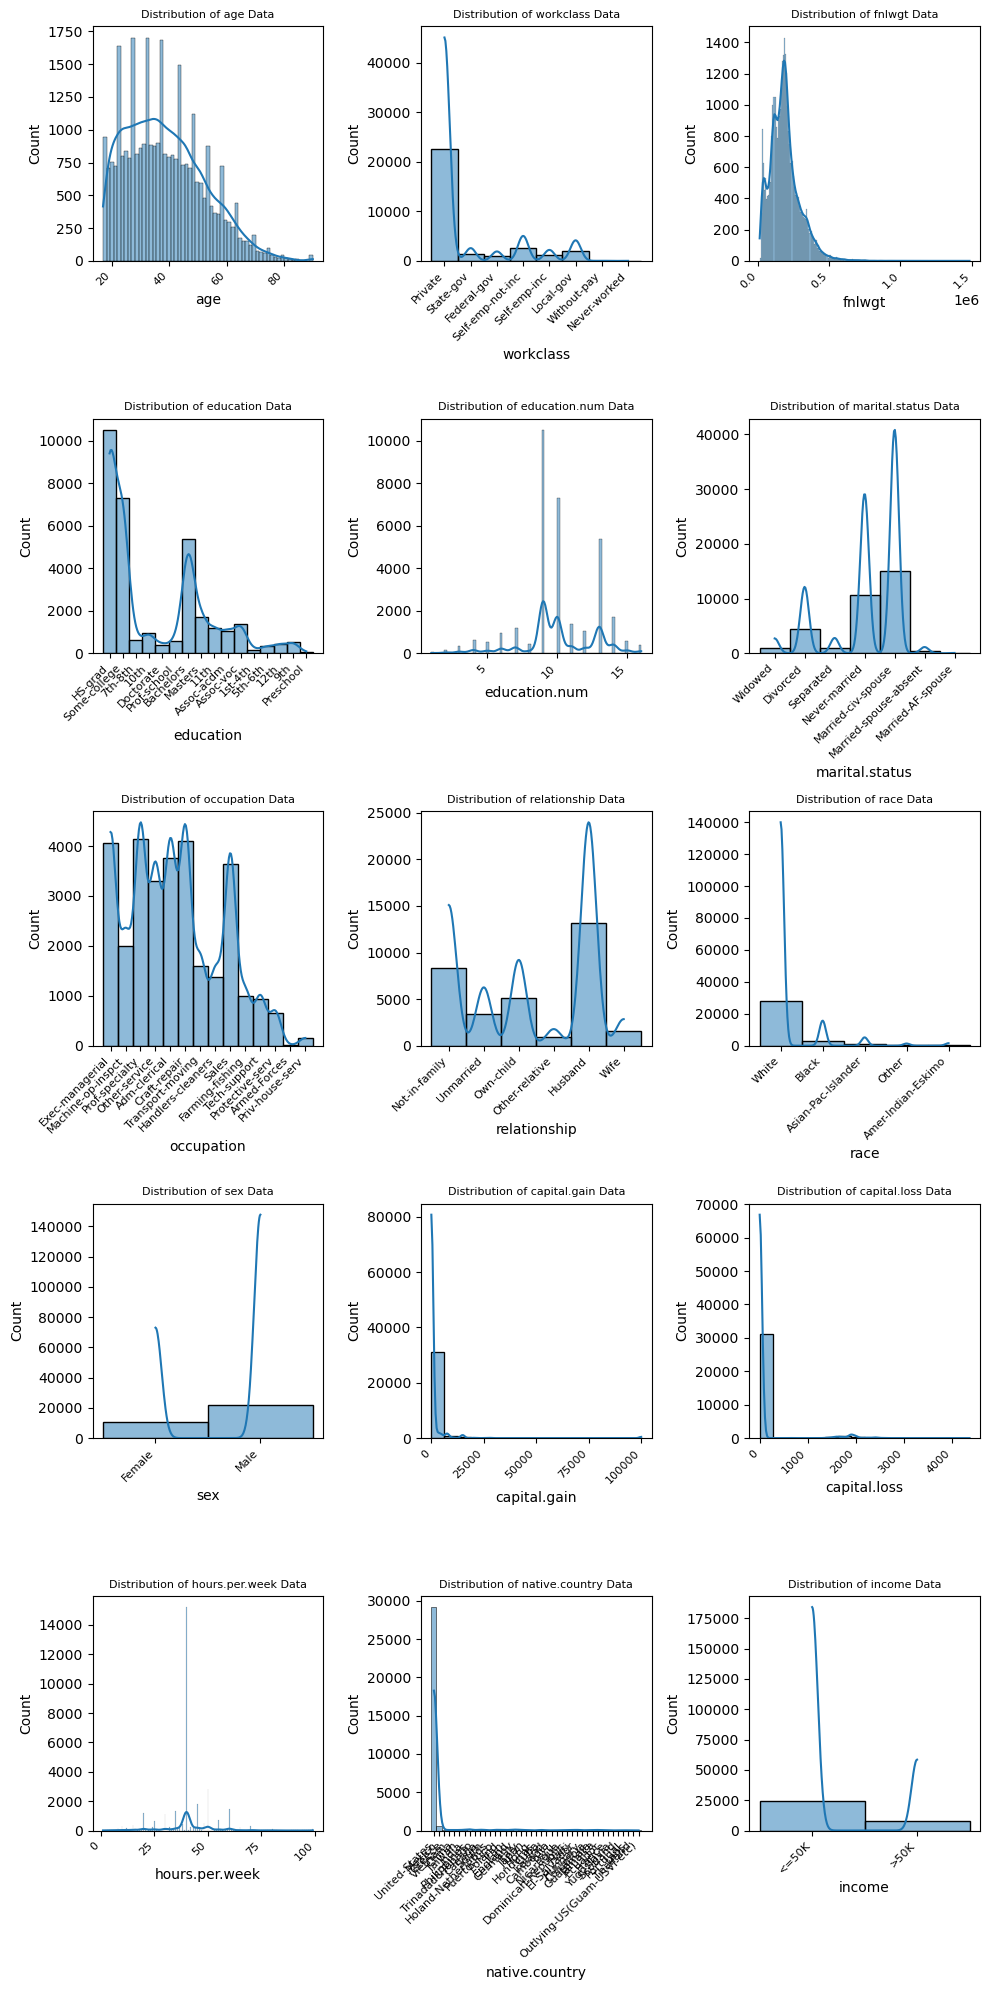

In [22]:
# Calculate number of columns and rows for the subplots
num_cols = df.iloc[:, :-1].shape[1]
num_rows = math.ceil(num_cols / 3)

# Set figure size
plt.figure(figsize=(10, 4 * num_rows))

for i, col in enumerate(df.iloc[:, :-1].columns, 1):
    plt.subplot(num_rows, 3, i)
    plt.title(f"Distribution of {col} Data", fontsize=8)  # Adjust title font size
    sns.histplot(df[col], kde=True)
    plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate x-axis labels and adjust font size
    plt.tight_layout()

# Show the plot
plt.show()

Visualizing feature distributions helps understanding the shape of data, spot unusual values (outliers), and see if the data is skewed. This can guide you in choosing the right methods, fixing data issues, and deciding how to prepare features for modeling.

The distribution of data influences the choice of algorithms. For example, some models DT and RF models are more robust to non-normal distributions, while others may require normally distributed features.

### Further Exploratory Data Analysis

#### Numerical features

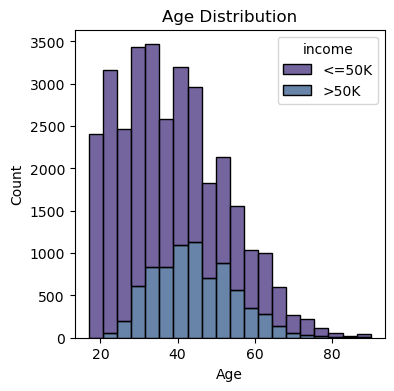

In [23]:
# Age distribution and income
plt.figure(figsize=(4, 4))
sns.set_palette("viridis")
sns.histplot(data=df, x='age', hue='income', bins=20, multiple='stack')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

The dataset shows that people with ages between 40 and 50 years old earn higher incomes than younger adults. A higher voumne of yourg adults earn less than 50K

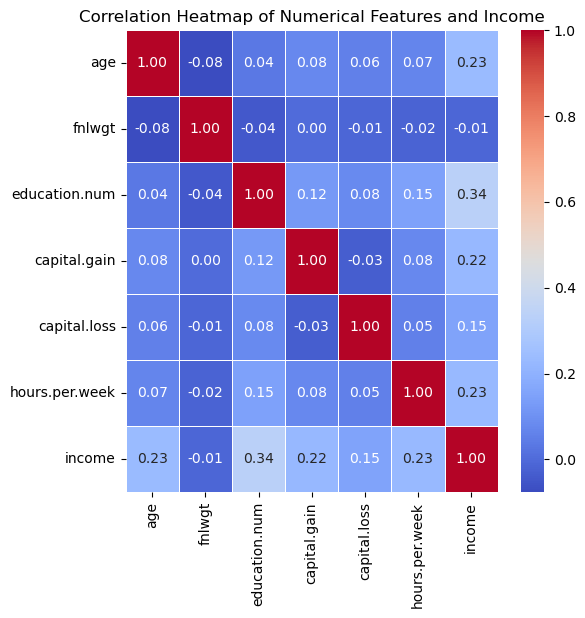

In [24]:
#Rest of numerical features
numerical_cols = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
target = 'income'

# Create a DataFrame with only the numerical columns and the target variable
correlation_df = df[numerical_cols + [target]].copy()

# Encode the target variable as numerical values (if it's categorical)
correlation_df[target] = correlation_df[target].apply(lambda x: 1 if x == '>50K' else 0)

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

# Plot the heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features and Income')
plt.show()

In [25]:
#To check for multicollinearity across numerical variables, you can calculate the Variance Inflation Factor (VIF) for each variable
#Checking multicolliniarity with Variance Inflation Factor (VIF):VIF quantifies how much the variance of a coefficient is inflated due to multicollinearity. 
#A VIF value above 10 (or sometime
# Define the numerical columns
numerical_cols = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

# Create a DataFrame with only the numerical columns
X = df[numerical_cols].copy()

# Add a constant to the DataFrame (required for VIF calculation)
X = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Format the output
pd.options.display.float_format = '{:.2f}'.format  
print(vif_data)

          feature   VIF
0           const 35.59
1             age  1.02
2          fnlwgt  1.01
3   education.num  1.04
4    capital.gain  1.03
5    capital.loss  1.01
6  hours.per.week  1.03


The numerical features exhibit low multicollinearity based on VIF values. This suggests that each feature contributes relatively independently to the model, which is favorable for creating a robust machine learning model

#### Categorical features

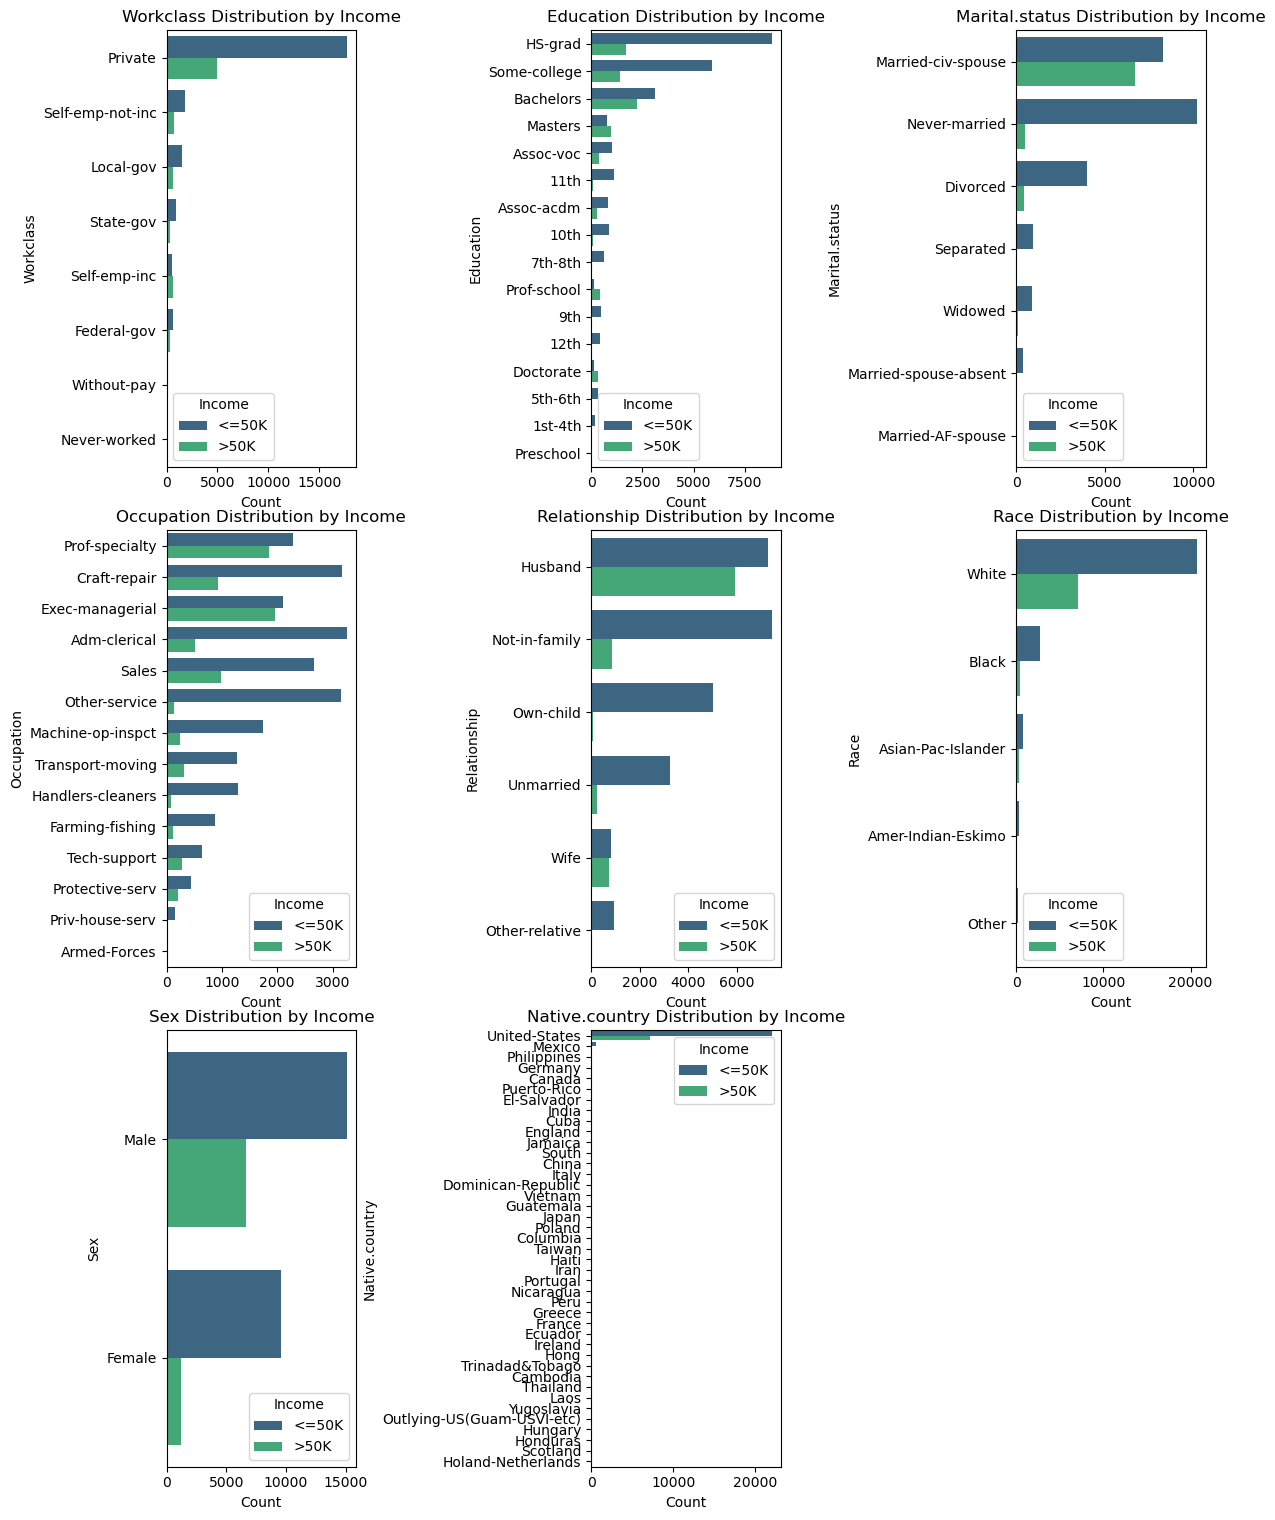

In [26]:
# categorical variables distribution and income
# Determine the number of rows needed
import seaborn as sns
import matplotlib.pyplot as plt

# Define the categorical variables
categorical_cols = [
    'workclass', 'education', 'marital.status', 'occupation', 
    'relationship', 'race', 'sex', 'native.country'
]

# Determine the number of rows needed
num_vars = len(categorical_cols)
num_cols = 3  # Number of columns per row
num_rows = (num_vars + num_cols - 1) // num_cols  # Compute the number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each categorical variable
for idx, var in enumerate(categorical_cols):
    sns.countplot(
        y=var, 
        hue='income', 
        data=df, 
        order=df[var].value_counts().index, 
        palette='viridis', 
        ax=axes[idx]
    )
    axes[idx].set_title(f'{var.capitalize()} Distribution by Income')
    axes[idx].set_xlabel('Count')
    axes[idx].set_ylabel(var.capitalize())
    
    # Rotate y-axis labels to prevent overlap
    axes[idx].tick_params(axis='y', labelrotation=0)
    
    # Add legend manually if needed
    handles, labels = axes[idx].get_legend_handles_labels()
    if handles:
        axes[idx].legend(handles, labels, title='Income')

# Remove empty subplots if any
for j in range(num_vars, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=0.0)  # Adjust layout to prevent overlap
plt.show()


In [27]:
#checking country of bith
df['native.country'].value_counts()

native.country
United-States                 29170
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                           29
France       

In [28]:
#checkinh hours.per.wee distribution
frequency_df = df['hours.per.week'].value_counts().reset_index()
frequency_df.columns = ['Hours Per Week', 'Frequency']

# Display the frequency DataFrame
print(frequency_df)

    Hours Per Week  Frequency
0               40      15217
1               50       2819
2               45       1824
3               60       1475
4               35       1297
..             ...        ...
89              94          1
90              82          1
91              92          1
92              87          1
93              74          1

[94 rows x 2 columns]


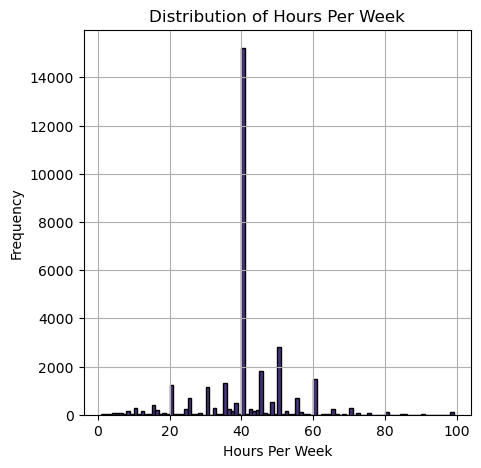

In [29]:
# Plot histogram for the 'hours.per.week' feature
plt.figure(figsize=(5, 5))
plt.hist(df['hours.per.week'], bins=range(int(df['hours.per.week'].min()), int(df['hours.per.week'].max()) + 1), edgecolor='black')
plt.title('Distribution of Hours Per Week')
plt.xlabel('Hours Per Week')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [30]:
# Get a summary of statistics for 'hours.per.week'
summary_stats = df['hours.per.week'].describe()
print("Summary Statistics:")
print(summary_stats)

Summary Statistics:
count   32561.00
mean       40.44
std        12.35
min         1.00
25%        40.00
50%        40.00
75%        45.00
max        99.00
Name: hours.per.week, dtype: float64


### Main observations

Main findings:

- There are two data problems that requires fixing before trainig a ML model. Missing data NaN and Data imbalance in the income class target
- The private sector is the largest group among work classes, leading to noticeable differences in income levels
- People who work without pay or have never worked typically fall into the low-income category
- Individuals with Bachelor's degrees tend to earn higher incomes
- Professional and managerial jobs result in higher pay, while service and manual labor jobs are associated with lower incomes. There are significant gender differences: men dominate technical and managerial roles, while women are more often found in clerical and service jobs
- The top three birth countries for people in the dataset are the US, Mexico, and the Philippines. Most people born in the US earn higher incomes
- Most white individuals earn higher salaries
- The data is heavily skewed, with most people earning less than $50K. Additionally, the dataset is predominantly composed of US-born individuals and those of white race, which could lead to biases that need to be carefully managed
- The strongest correlations between numerical features and income are age, hours worked per week, capital gains, and years of education
- There are no concerns about multicollinearity in the data


Based on the EDA the features that have high correlation and relevant to explain income are:

Categorical features: Workclass, education, marital.status, occupation, relationship, race, sex and native.country

Numerical fetures: age, capital gain, capital loss, and hours per week

The numerical features fnlwgt (final weight:the number of people the census believes the entry represents) and education.num are dropped from the model. fnlwgt  does not have a significant relationship with income. education.num  the highest level of education achieved in numerical form. This is already captured in the categporical variable education.

### Handling NaN Missing Data

There are multiple techniques used to handle missing data. These includes simple Data Imputation in which missing values are filled in a dataset. This process involves using methods like averages or predictions to estimate these missing values. There are two main ways to create these estimates by using explici or implicit modeling.

Explicit Modeling: Building a model to predict the missing values based on the data you already have. This technique uses a clear statistical model, like a multivariate normal distribution, to predict missing values. It’s based on specific assumptions. Examples include:

Average Imputation: Replacing missing values with the average of existing values.
Regression Imputation: Using a regression model to predict missing values.
Stochastic Regression Imputation: Adding some randomness to the predictions made by a regression model.

Implicit Modeling: Using simpler methods like averages or general rules without creating a detailed model. This technique uses algorithms that suggest an underlying model without stating it clearly. You still need to check if the assumptions are reasonable. Examples include:

Hot Deck Imputation: Filling in missing values with similar values from other records.
Imputation by Replacement: Replacing missing values with predefined values or methods.
Cold Deck Imputation: Using an external source to provide values for missing data.

The Census Institute in the USA often uses Hot Deck Imputation to handle missing values. This method involves filling in missing values with data from similar, complete records. It helps ensure that the imputed values are realistic and consistent with the data distribution.

However, the missing values in this project will be removed as the dataset is quite large and only 3 categorical variables workclass, occupation and native.country includes missing data. By removing NaN values, the dataset size was reduced from 32,561 to 30,162. However, since SMOTE will be used to address class imbalance, the number of samples will increase, alleviating concerns about losing too much information from the NaN removal. This approach prioritizes handling class imbalance with SMOTE rather than using imputation methods, ensuring that the dataset retains its utility and balance. SMOTE increases the number of minority class samples by making new, similar samples, helping to balance the dataset without simply duplicating existing data. For each sample in the minority class, SMOTE finds its nearest neighbors in the feature space.



In [31]:
# Create a copy of the original dataset
df_2 = df.copy()

# Replace '?' with NaN
df_2[df_2 == '?'] = np.nan

In [32]:
#Drop NaN from Income Census dataset
df_2 = df_2.dropna(axis=0)
df_2

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,income_class
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K,0
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K,0
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K,0
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K,0
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,0
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,1
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,0


### 1.1 Feature Creation

#### New created Binary target class: income

In [33]:
#target class income <=50K =0 and income >50K=1
df_2['income'] = df_2['income'].map({'<=50K': 0, '>50K': 1}) # positive class is '>50K'

# Convert to integer type explicitly
df_2['income'] = df_2['income'].astype(int)

In [34]:
df_2.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,income_class
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0,0
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0,0
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0,0
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,0,0
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,0,0


In [35]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 1 to 32560
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   fnlwgt          30162 non-null  int64 
 3   education       30162 non-null  object
 4   education.num   30162 non-null  int64 
 5   marital.status  30162 non-null  object
 6   occupation      30162 non-null  object
 7   relationship    30162 non-null  object
 8   race            30162 non-null  object
 9   sex             30162 non-null  object
 10  capital.gain    30162 non-null  int64 
 11  capital.loss    30162 non-null  int64 
 12  hours.per.week  30162 non-null  int64 
 13  native.country  30162 non-null  object
 14  income          30162 non-null  int32 
 15  income_class    30162 non-null  int64 
dtypes: int32(1), int64(7), object(8)
memory usage: 3.8+ MB


#### New age ranges column

In [36]:
#Ages by groups
# Having ages in ranges are quite meaningful to identify ages groups and incomes. The working age populaiton is usually identified between ages 18years and 60 years. So, the age ranges will be distributed to have as last bin over 60 years old.
# Define the edges of the bins with the last bin being 60 and above
# Define bins and labels for age ranges
bins = [17, 29, 39, 59, 90]  # 90 years old is the maximum age
labels = ['17-29', '30-39', '40-59', '60 and above']

# Create a new column 'age.range' based on the bins
df_2.loc[:, 'age.range'] = pd.cut(df_2['age'].astype(int), bins=bins, labels=labels, right=True)

# Calculate counts of age ranges
age_group_counts = df_2.groupby('age.range', observed=False)['age'].count()
print(age_group_counts)

age.range
17-29            8456
30-39            8211
40-59           11085
60 and above     2082
Name: age, dtype: int64


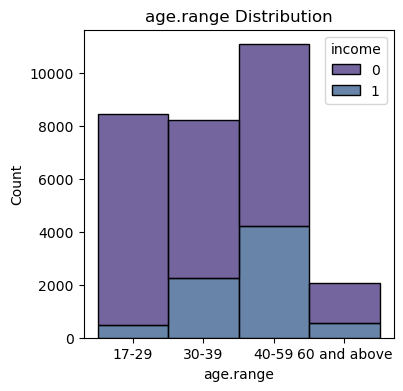

In [37]:
#Age ranges and income
plt.figure(figsize=(4, 4))
sns.set_palette("viridis")
sns.histplot(data=df_2, x='age.range', hue='income', bins=20, multiple='stack')
plt.xlabel('age.range')
plt.ylabel('Count')
plt.title('age.range Distribution')
plt.show()

The age ranges with the highest number of people are 40 to 59 folooed by 17-29. This is important to understand income patterns. The income is higher for people age 0-59 an dlower for people age 17-29

#### New Education and Married Status  grouped column

Education, Marital status conains to many categories.Therefore, thoe categories are gropued to ease the undresatding and model performance

In [38]:
# Define replacement mapping for education
education_mapping = {
    '1st-4th': 'elementary_school',
    '5th-6th': 'elementary_school',
    '7th-8th': 'secondary_school',
    '9th': 'secondary_school',
    '10th': 'secondary_school',
    '11th': 'secondary_school',
    '12th': 'secondary_school',
    'Assoc-acdm': 'Assoc',
    'Assoc-voc': 'Assoc'
}

# Create a new column 'education.group' based on the mapping
df_2.loc[:,'education.group'] = df_2['education'].replace(education_mapping)

# Verify the changes
print(df_2[['education', 'education.group']].head())

      education   education.group
1       HS-grad           HS-grad
3       7th-8th  secondary_school
4  Some-college      Some-college
5       HS-grad           HS-grad
6          10th  secondary_school


In [39]:
#Married status is combined as follows

In [40]:
# Replace values in 'marital.status' column
marital_status_mapping = {
    'Never-married': 'NotMarried',
    'Married-AF-spouse': 'Married',
    'Married-civ-spouse': 'Married',
    'Married-spouse-absent': 'Separated',
    'Separated': 'Separated',
    'Divorced': 'Divorced',
    'Widowed': 'Widowed'
}

# Create a new column 'marital.status.group' based on the mapping
df_2.loc[:,'marital.status.group'] = df_2['marital.status'].replace(marital_status_mapping)

# Verify the changes
print(df_2[['marital.status', 'marital.status.group']].head())

  marital.status marital.status.group
1        Widowed              Widowed
3       Divorced             Divorced
4      Separated            Separated
5       Divorced             Divorced
6      Separated            Separated


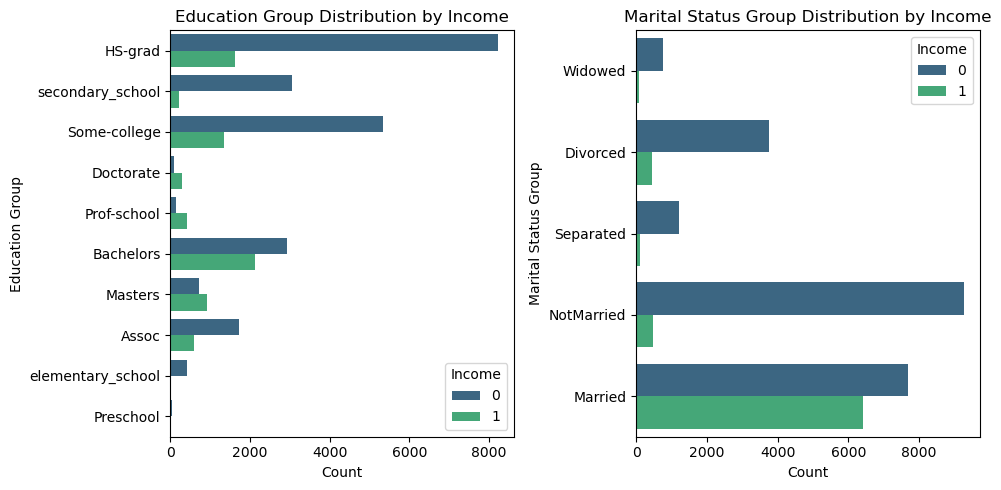

In [41]:
# Create subplots education_group and married_status_group

fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Plot education_group distribution by income
sns.countplot(
    y='education.group', 
    hue='income', 
    data=df_2, 
    palette='viridis', 
    ax=axes[0]
)
axes[0].set_title('Education Group Distribution by Income')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Education Group')
axes[0].legend(title='Income')

# Plot marital.status_group distribution by income
sns.countplot(
    y='marital.status.group', 
    hue='income', 
    data=df_2, 
    palette='viridis', 
    ax=axes[1]
)
axes[1].set_title('Marital Status Group Distribution by Income')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Marital Status Group')
axes[1].legend(title='Income')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

#### New Capital Net Gain grouped column

Combining capital.gain and capital.loss columns into a new column called Net capital gain easy the model perfomance

In [42]:
#New column capital gain
df_2['capital.Net.Gain'] = df_2['capital.gain'] - df_2['capital.loss']

# Bin the Net Gain into 'Low' and 'High' categories
df_2['capital.Net.Gain'] = pd.cut(df_2['capital.Net.Gain'], bins=[-5000, 5000, 100000], labels=['Low', 'High'])

# Ensure 'capital.Net.Gain' is of type 'object'
df_2['capital.Net.Gain'] = df_2['capital.Net.Gain'].astype('object')

# Display the updated DataFrame
print(df_2[['capital.gain', 'capital.loss', 'capital.Net.Gain']].head())

   capital.gain  capital.loss capital.Net.Gain
1             0          4356              Low
3             0          3900              Low
4             0          3900              Low
5             0          3770              Low
6             0          3770              Low


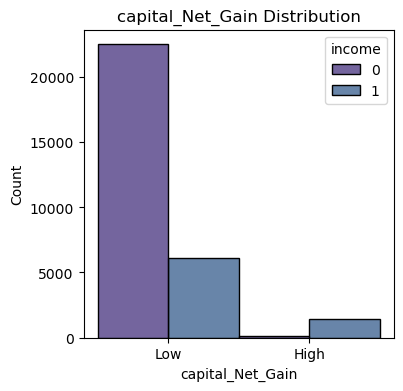

In [43]:
# Capitla Net gain distribution and income
plt.figure(figsize=(4, 4))
sns.set_palette("viridis")
sns.histplot(data=df_2, x='capital.Net.Gain', hue='income', bins=20, multiple="dodge")
plt.xlabel('capital_Net_Gain')
plt.ylabel('Count')
plt.title('capital_Net_Gain Distribution')
plt.show()

#### New native.country grouped column

In [44]:
# Define a threshold for grouping
threshold = 50

# Count occurrences of each country
country_counts = df_2['native.country'].value_counts()

# Define a list of countries to keep
countries_to_keep = country_counts[country_counts > threshold].index

# Group the rest into 'Other'
df_2.loc[:,'native.country.group'] = df_2['native.country'].apply(lambda x: x if x in countries_to_keep else 'Other')

# Verify the grouping
print(df_2['native.country.group'].value_counts())

native.country.group
United-States         27504
Mexico                  610
Other                   486
Philippines             188
Germany                 128
Puerto-Rico             109
Canada                  107
El-Salvador             100
India                   100
Cuba                     92
England                  86
Jamaica                  80
South                    71
Italy                    68
China                    68
Dominican-Republic       67
Vietnam                  64
Guatemala                63
Japan                    59
Columbia                 56
Poland                   56
Name: count, dtype: int64


In [45]:
df_2.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,...,capital.loss,hours.per.week,native.country,income,income_class,age.range,education.group,marital.status.group,capital.Net.Gain,native.country.group
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,...,4356,18,United-States,0,0,60 and above,HS-grad,Widowed,Low,United-States
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,...,3900,40,United-States,0,0,40-59,secondary_school,Divorced,Low,United-States
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,...,3900,40,United-States,0,0,40-59,Some-college,Separated,Low,United-States
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,...,3770,45,United-States,0,0,30-39,HS-grad,Divorced,Low,United-States
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,...,3770,40,United-States,0,0,30-39,secondary_school,Separated,Low,United-States


### 1.2 Feature Transformation

In [46]:
# Features to be analaysed
features = ['age.range', 'workclass', 'education.group',
    'marital.status.group', 'occupation', 'relationship', 'race', 'sex',
    'capital.Net.Gain', 'hours.per.week', 'native.country.group'
]

In [47]:
df_2

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,...,capital.loss,hours.per.week,native.country,income,income_class,age.range,education.group,marital.status.group,capital.Net.Gain,native.country.group
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,...,4356,18,United-States,0,0,60 and above,HS-grad,Widowed,Low,United-States
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,...,3900,40,United-States,0,0,40-59,secondary_school,Divorced,Low,United-States
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,...,3900,40,United-States,0,0,40-59,Some-college,Separated,Low,United-States
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,...,3770,45,United-States,0,0,30-39,HS-grad,Divorced,Low,United-States
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,...,3770,40,United-States,0,0,30-39,secondary_school,Separated,Low,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,...,0,40,United-States,0,0,17-29,Some-college,NotMarried,Low,United-States
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,...,0,38,United-States,0,0,17-29,Assoc,Married,Low,United-States
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,...,0,40,United-States,1,1,40-59,HS-grad,Married,Low,United-States
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,...,0,40,United-States,0,0,40-59,HS-grad,Widowed,Low,United-States


#### Splitting data train and test

In [48]:
# Split data into features and target variable
X = df_2[features]
y = df_2['income']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### One Hot Encoding categorical features and MinMAxScaler numerical features

In [49]:
# List of categorical and numerical features
categorical_features = ['age.range', 'workclass', 'education.group', 'marital.status.group', 
                         'occupation', 'relationship', 'race', 'sex', 'native.country.group','capital.Net.Gain']

numerical_features = ['hours.per.week']

# Define pipeline with dense output
transformation = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),  # Scale numerical features
        ('cate', OneHotEncoder(sparse=False,drop='first'), categorical_features)  # One-hot encode categorical features with dense output
    ]
)

# Fit and transform training data, and transform test data
X_train_transformed = transformation.fit_transform(X_train)
X_test_transformed  = transformation.transform(X_test)

# Verify the type of output
X_train_transformed 

array([[0.44897959, 1.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.1122449 , 0.        , 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.44897959, 0.        , 1.        , ..., 1.        , 0.        ,
        1.        ],
       ...,
       [0.39795918, 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.5       , 1.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.60204082, 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ]])

#### Mapping Encoded Columns to Original Features

In [50]:
# Get feature names for categorical features
transformation.fit(X_train)

# Get feature names for categorical features
cate_ori = transformation.named_transformers_['cate']
categorical_feature_names = cate_ori.get_feature_names_out(categorical_features)

# Create a list to hold the mapping
mapping = []

# Loop over the categorical features and corresponding one-hot encoded features
for feature in categorical_features:
    # Get the corresponding one-hot encoded columns
    one_hot_encoded_columns = [col for col in categorical_feature_names if col.startswith(feature)]
    
    # Append to the mapping list
    mapping.append({
        'Original Feature': feature,
        'One-Hot Encoded Features': ", ".join(one_hot_encoded_columns)
    })

# Create a DataFrame from the mapping list
mapping_df = pd.DataFrame(mapping)

# Display the mapping table
print(mapping_df)

       Original Feature                           One-Hot Encoded Features
0             age.range  age.range_30-39, age.range_40-59, age.range_60...
1             workclass  workclass_Local-gov, workclass_Private, workcl...
2       education.group  education.group_Bachelors, education.group_Doc...
3  marital.status.group  marital.status.group_Married, marital.status.g...
4            occupation  occupation_Armed-Forces, occupation_Craft-repa...
5          relationship  relationship_Not-in-family, relationship_Other...
6                  race  race_Asian-Pac-Islander, race_Black, race_Othe...
7                   sex                                           sex_Male
8  native.country.group  native.country.group_China, native.country.gro...
9      capital.Net.Gain                               capital.Net.Gain_Low


#### Mapping Scaled Columns to Original Features

In [51]:
# Extract original numerical features from the training set
original_numerical_df = X_train[numerical_features].reset_index(drop=True)

# Extract scaled numerical features from the transformed data
scaled_numerical_df = pd.DataFrame(X_train_transformed[:, :len(numerical_features)], 
                                   columns=[f"Scaled {col}" for col in numerical_features]).reset_index(drop=True)

# Combine both original and scaled features into one DataFrame
comparison_df = pd.concat([original_numerical_df, scaled_numerical_df], axis=1)
comparison_df.columns = [f"Original {col}" for col in numerical_features] + [f"Scaled {col}" for col in numerical_features]

# Drop duplicates based on the scaled features
unique_comparison_df = comparison_df.drop_duplicates(subset=[f"Scaled {col}" for col in numerical_features])

# Sort by 'Original hours.per.week' in ascending order
sorted_comparison_df = unique_comparison_df.sort_values(by='Original hours.per.week').reset_index(drop=True)

# Display all rows (if needed)
pd.set_option('display.max_rows', None)  # Remove this line if you want to limit rows displayed

# Display the sorted DataFrame
print(sorted_comparison_df)

    Original hours.per.week  Scaled hours.per.week
0                         1                   0.00
1                         2                   0.01
2                         3                   0.02
3                         4                   0.03
4                         5                   0.04
5                         6                   0.05
6                         7                   0.06
7                         8                   0.07
8                         9                   0.08
9                        10                   0.09
10                       11                   0.10
11                       12                   0.11
12                       13                   0.12
13                       14                   0.13
14                       15                   0.14
15                       16                   0.15
16                       17                   0.16
17                       18                   0.17
18                       19    

## 2. Feature Selection 

#### Using Random Forest and Principal Component Analysis to get feature importance
RF and PCA are applied  to get feature importance to identify which features, particularly among the one-hot encoded categorical variables, are most important in predicting the target variable (income)

In [52]:
#This are all features wih tone hot encoded
feature_names = transformation.get_feature_names_out()

# Display feature names
print(feature_names)

# Print the total number of feature names
print("Total number of features:", len(feature_names))

['num__hours.per.week' 'cate__age.range_30-39' 'cate__age.range_40-59'
 'cate__age.range_60 and above' 'cate__age.range_nan'
 'cate__workclass_Local-gov' 'cate__workclass_Private'
 'cate__workclass_Self-emp-inc' 'cate__workclass_Self-emp-not-inc'
 'cate__workclass_State-gov' 'cate__workclass_Without-pay'
 'cate__education.group_Bachelors' 'cate__education.group_Doctorate'
 'cate__education.group_HS-grad' 'cate__education.group_Masters'
 'cate__education.group_Preschool' 'cate__education.group_Prof-school'
 'cate__education.group_Some-college'
 'cate__education.group_elementary_school'
 'cate__education.group_secondary_school'
 'cate__marital.status.group_Married'
 'cate__marital.status.group_NotMarried'
 'cate__marital.status.group_Separated'
 'cate__marital.status.group_Widowed' 'cate__occupation_Armed-Forces'
 'cate__occupation_Craft-repair' 'cate__occupation_Exec-managerial'
 'cate__occupation_Farming-fishing' 'cate__occupation_Handlers-cleaners'
 'cate__occupation_Machine-op-inspct

Variance explained by each feature was calculated 73% of variance is explained by top 20 features, while 99% is explained by the top 60. There are 70 total features including one-hot encoding columns. There are 11 features in the original dataframe

In [53]:
# Initialize and train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)  # Use parallel processing to make calcculationsquicker
rf.fit(X_train_transformed, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test_transformed)


In [54]:
# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame with feature names and their importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top features
print(importance_df.head(60))

                                     Feature  Importance
0                        num__hours.per.week        0.18
20        cate__marital.status.group_Married        0.11
67                cate__capital.Net.Gain_Low        0.10
21     cate__marital.status.group_NotMarried        0.05
2                      cate__age.range_40-59        0.03
46                            cate__sex_Male        0.03
26          cate__occupation_Exec-managerial        0.03
11           cate__education.group_Bachelors        0.03
32           cate__occupation_Prof-specialty        0.03
13             cate__education.group_HS-grad        0.02
19    cate__education.group_secondary_school        0.02
1                      cate__age.range_30-39        0.02
6                    cate__workclass_Private        0.02
37          cate__relationship_Not-in-family        0.02
14             cate__education.group_Masters        0.02
39              cate__relationship_Own-child        0.02
17        cate__education.group

In [55]:
# Calculate cumulative variance explained by top N features

top_20_importance = importance_df.head(20)['Importance'].sum()
top_60_importance = importance_df.head(60)['Importance'].sum()
total_importance = importance_df['Importance'].sum()

variance_explained_20 = top_20_importance / total_importance
variance_explained_60 = top_60_importance / total_importance

print(f"Variance explained by top 20 features: {variance_explained_20:.2%}")
print(f"Variance explained by top 60 features: {variance_explained_60:.2%}")

Variance explained by top 20 features: 78.99%
Variance explained by top 60 features: 99.86%


                      Importance
Original Feature                
hours.per.week              0.18
marital.status.group        0.17
education.group             0.14
occupation                  0.13
capital.Net.Gain            0.10
age.range                   0.07
workclass                   0.07
relationship                0.07
native.country.group        0.03
sex                         0.03
race                        0.02


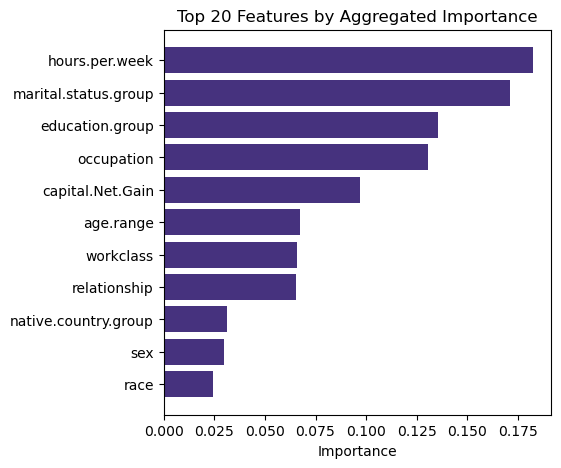

In [56]:
# Aggregate the importances by original feature name

importance_df['Original Feature'] = importance_df['Feature'].apply(lambda x: x.split('__')[1].split('_')[0])

# Sum the importances by original feature
aggregated_importance = importance_df.groupby('Original Feature')['Importance'].sum().reset_index()

# Sort by importance
aggregated_importance = aggregated_importance.sort_values(by='Importance', ascending=False)

# Plot the top 20 features
fig, ax = plt.subplots(figsize=(5, 5))  # Set the figure size
# Create horizontal bar plot
ax.barh(aggregated_importance['Original Feature'].head(60), aggregated_importance['Importance'].head(20))
ax.invert_yaxis()  # Invert y-axis to have the most important feature at the top
ax.set_xlabel('Importance')
ax.set_title('Top 20 Features by Aggregated Importance')

# Prepare the table data with top nfeatures
table_data = aggregated_importance.head(60).set_index('Original Feature')

# Print the table data
print(table_data)


### Create dataframe wiht top 60 features to be used in the Model creation step

In [57]:
# List of top 60 feature names (adjust this based on your feature importance DataFrame)
top_60_features = importance_df.head(60)['Feature'].tolist()
# Find indices of top 60 features in the transformed feature names
top_60_indices = [list(feature_names).index(feature) for feature in top_60_features if feature in feature_names]

# Select columns from X_train_transformed using indices
X_train_top_60 = X_train_transformed[:, top_60_indices]


The top features selected for training different ML models based on their importance scores are shownn below. These features refer to the original features used in the dataset. The total number of features includes 60, which accounts for the combinations created by one-hot encoding 

Numerical:
- Hours per Week

Categorical:
- Marital Status Group
- Education Group
- Occupation
- Capital Net Gain
- Age Range
- Workclass
- Relationship
- Native Country Group
- Sex
- Race

#### Handling Data imbalance using SMOTE to balance the classes in the training dataset

The SMOTE (Synthetic Minority Over-sampling Technique) is a method to create extra samples for the less common class in your training data to balance it out. You should only apply SMOTE to the training data, not the test data. This is important because you want the test data to represent the real-world class distribution to properly assess how well your model performs

SMOTE balance the classes in y_train by oversampling the minority class. This approach will balance your dataset by generating synthetic samples of the minority class, and you can then proceed with training your model on the balanced dataset

After applying SMOTE, the dataset has grown to 36,242 samples, maintaining the same number of features (78). This indicates that SMOTE has generated additional samples to balance the minority class, increasing the total number of samples

In [58]:
# Initialize SMOTE
# Define SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the transformed training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

In [59]:
print(f"Original dataset shape: {X_train_transformed.shape}, {y_train.shape}")
print(f"SMOTE dataset shape: {X_train_smote.shape}, {y_train_smote.shape}")

Original dataset shape: (24129, 68), (24129,)
SMOTE dataset shape: (36242, 68), (36242,)


## 3. Model Creation and Evaluation

#### Decision Tree (DT), Random Forest (RF) and Logistic Regression (LR)

Confusion matrix:
[[3862  671]
 [ 476 1024]]


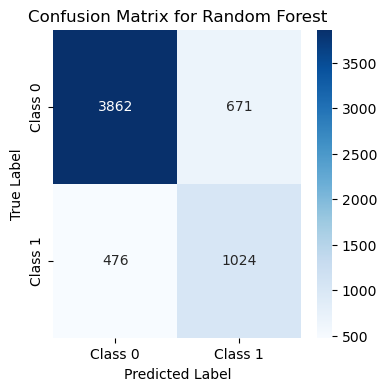

Confusion matrix:
[[3836  697]
 [ 536  964]]


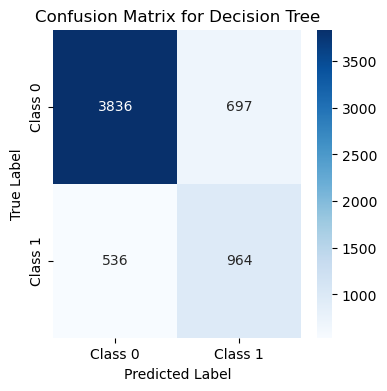

Confusion matrix:
[[3618  915]
 [ 241 1259]]


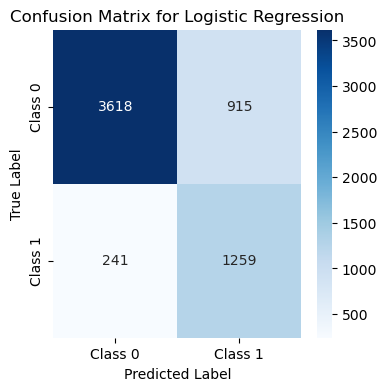

,Model,Accuracy (%),Precision (Class 0),Precision (Class 1),Recall (Class 0),Recall (Class 1),F1-Score (Class 0),F1-Score (Class 1),ROC-AUC Score
0,Random Forest,80.99,0.89,0.60,0.85,0.68,0.87,0.64,0.87
1,Decision Tree,79.56,0.88,0.58,0.85,0.64,0.86,0.61,0.79
2,Logistic Regression,80.84,0.94,0.58,0.80,0.84,0.86,0.69,0.90


In [60]:
# Define and train models with default parameters
models = {
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=2000)  # `max_iter` is increased to ensure convergence
}

# Initialize a list to store metrics
results = []

# Evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train_smote, y_train_smote)
    
    # Make predictions
    y_pred = model.predict(X_test_transformed)
    y_prob = model.predict_proba(X_test_transformed)[:, 1]  # Probabilities for the positive class
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:")
    print(cm)
    
  # Plot confusion matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], 
                yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
    
    # Store the results
    results.append({
        'Model': name,
        'Accuracy (%)': accuracy,
        'Precision (Class 0)': precision[0],
        'Precision (Class 1)': precision[1],
        'Recall (Class 0)': recall[0],
        'Recall (Class 1)': recall[1],
        'F1-Score (Class 0)': f1[0],
        'F1-Score (Class 1)': f1[1],
        'ROC-AUC Score': roc_auc
    })
    
 # Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the summary table
results_df


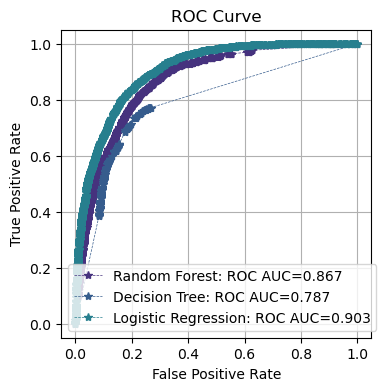

In [61]:
# Evaluate each model
# Initialize an empty dictionary to store probabilities
model_probs = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train_smote, y_train_smote)
    
    # Predict probabilities for the test data
    probs = model.predict_proba(X_test_transformed)
    
    # Keep probabilities for the positive outcome only
    probs_positive = probs[:, 1]
    
    # Store probabilities
    model_probs[name] = probs_positive

# Calculate scores
# For random predictions
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)

# Plot ROC curves
plt.figure(figsize=(4,4))

for name, probs_positive in model_probs.items():
    auc = roc_auc_score(y_test, probs_positive)
    fpr, tpr, _ = roc_curve(y_test, probs_positive)
    plt.plot(fpr, tpr, linestyle='--', marker='*', linewidth=0.5, label=f'{name}: ROC AUC={auc:.3f}')


# Axis labels and plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

After removing NaN values from the dataset, reducing the sample size from 32,561 to 30,162, I applied SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance. The resulting data was split into training and test sets, with a preprocessing pipeline defined to scale numerical features and one-hot encode categorical features. Models including Random Forest, Decision Tree, and Logistic Regression (with increased max_iter for convergence) were trained on the SMOTE-processed data and evaluated. The performance metrics—accuracy, ROC-AUC score, precision, recall, F1 score, and support—were computed, and confusion matrices were plotted for each model. All results were compiled into a summary table using pandas and visualized with seaborn for detailed model comparison.

## 4. Use DT and RF to extract interesting rules discovery

In many situations, especially when using machine learning for important decisions, it's not just about getting accurate predictions. It's also important to understand the model so experts can gain valuable insights. To address this, interpretable and explainable machine learning has become more popular, especially for classification problems. In classification, the main goal is to create a model that correctly assigns data points to one of two or more distinct categories.

Extracting interesting classification rules from the Census Income dataset using concepts like conciseness, coverage, reliability, peculiarity, diversity, novelty, surprisingness, utility and actionable.

By identifying and analyzing these rules, we can derive actionable insights that not only help in predicting income but also provide meaningful guidance for decision-making, policy formulation, or targeted interventions based on the Census Income data.

#### Plotting DT

The DT plot has 9,861 nodes is no readible ina graph. A Max_depth=2 has been selected to get a clear undersatnding of rule sin the chart

To display the decision rules of a Decision Tree model line by line without a graphical plot, you can extract and print the rules programmatically

In [62]:
# Structure of tree
DT_model = models['Decision Tree']

# Count the number of nodes

tree_ = DT_model.tree_

# Count the number of nodes
num_nodes = tree_.node_count

# Count the number of leaf nodes
num_leaves = np.sum(tree_.children_left == -1)  # Leaf nodes where children_left is -1

print(f"The Decision Tree model contains {num_nodes} nodes.")
print(f"The Decision Tree model contains {num_leaves} leaf nodes.")


The Decision Tree model contains 9861 nodes.
The Decision Tree model contains 4931 leaf nodes.


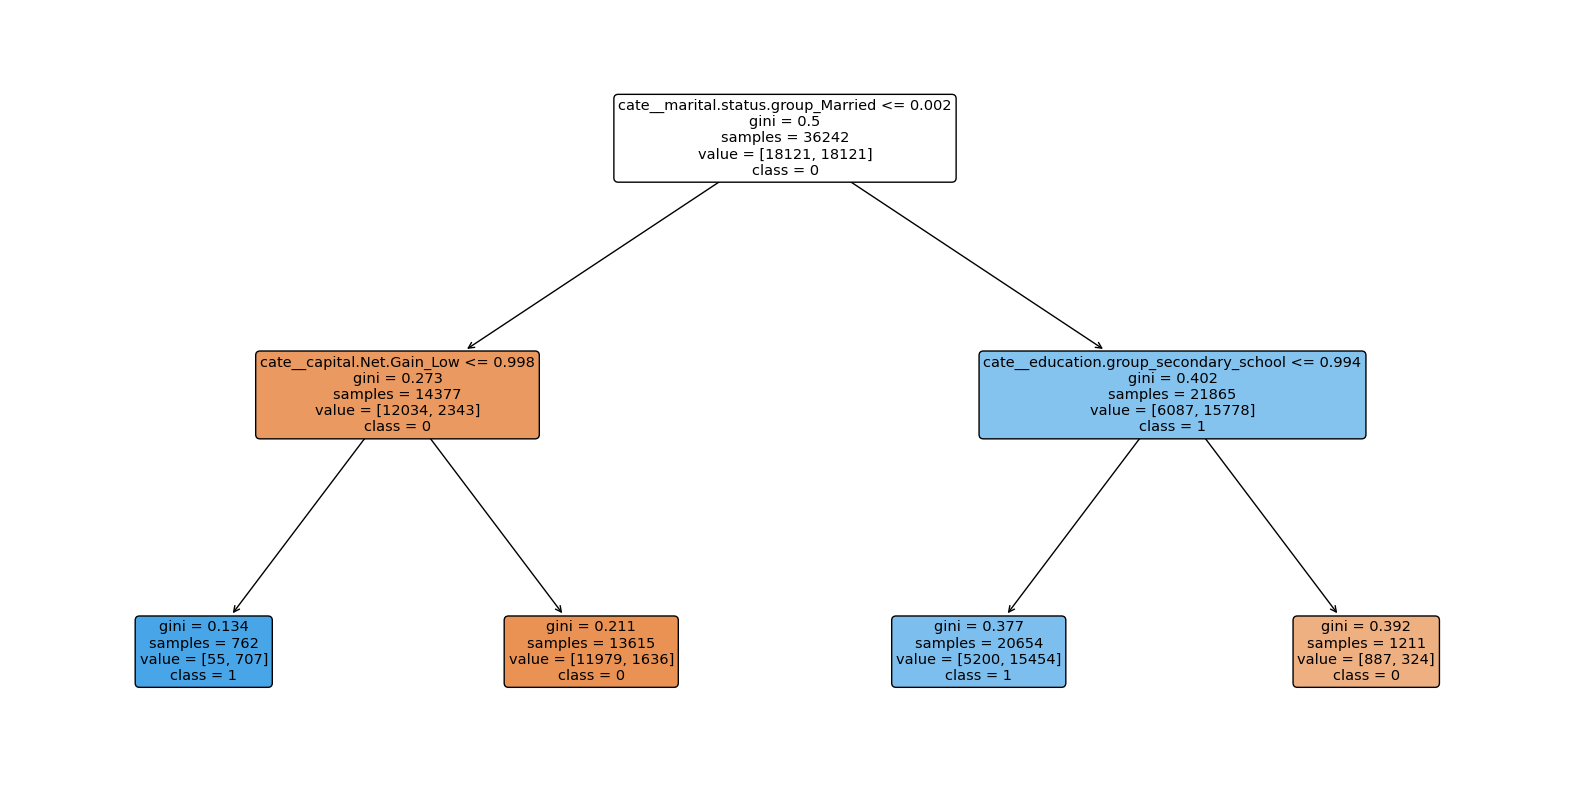

In [63]:
# Convert the NumPy array to DataFrame
X_train_smote_df = pd.DataFrame(X_train_smote, columns=feature_names)

# Plot the Decision Tree
class_names = ['0', '1']  # 0 for <=50K, 1 for >50K

# Train the Decision Tree model with a reasonable max_depth
dt_model = DecisionTreeClassifier(max_depth=2, random_state=42)  # Adjust max_depth as needed
dt_model.fit(X_train_smote_df, y_train_smote)

# Plot the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=feature_names, class_names=class_names, filled=True, rounded=True)
plt.show()

The DecisionTreeClassifier can be used to extract the decision rules from the trained model

In [64]:
# Extract the decision rules from the fitted Decision Tree model
decision_rules = export_text(dt_model, feature_names=list(feature_names))

# Print the decision rules
print(decision_rules)

|--- cate__marital.status.group_Married <= 0.00
|   |--- cate__capital.Net.Gain_Low <= 1.00
|   |   |--- class: 1
|   |--- cate__capital.Net.Gain_Low >  1.00
|   |   |--- class: 0
|--- cate__marital.status.group_Married >  0.00
|   |--- cate__education.group_secondary_school <= 0.99
|   |   |--- class: 1
|   |--- cate__education.group_secondary_school >  0.99
|   |   |--- class: 0



Decision Rules with max_depth=2:

|--- cate__marital.status.group_Married <= 0.00
|   |--- cate__capital.Net.Gain_Low <= 1.00
|   |   |--- class: 1
|   |--- cate__capital.Net.Gain_Low >  1.00
|   |   |--- class: 0
|--- cate__marital.status.group_Married >  0.00
|   |--- cate__education.group_secondary_school <= 0.99
|   |   |--- class: 1
|   |--- cate__education.group_secondary_school >  0.99
|   |   |--- class: 0



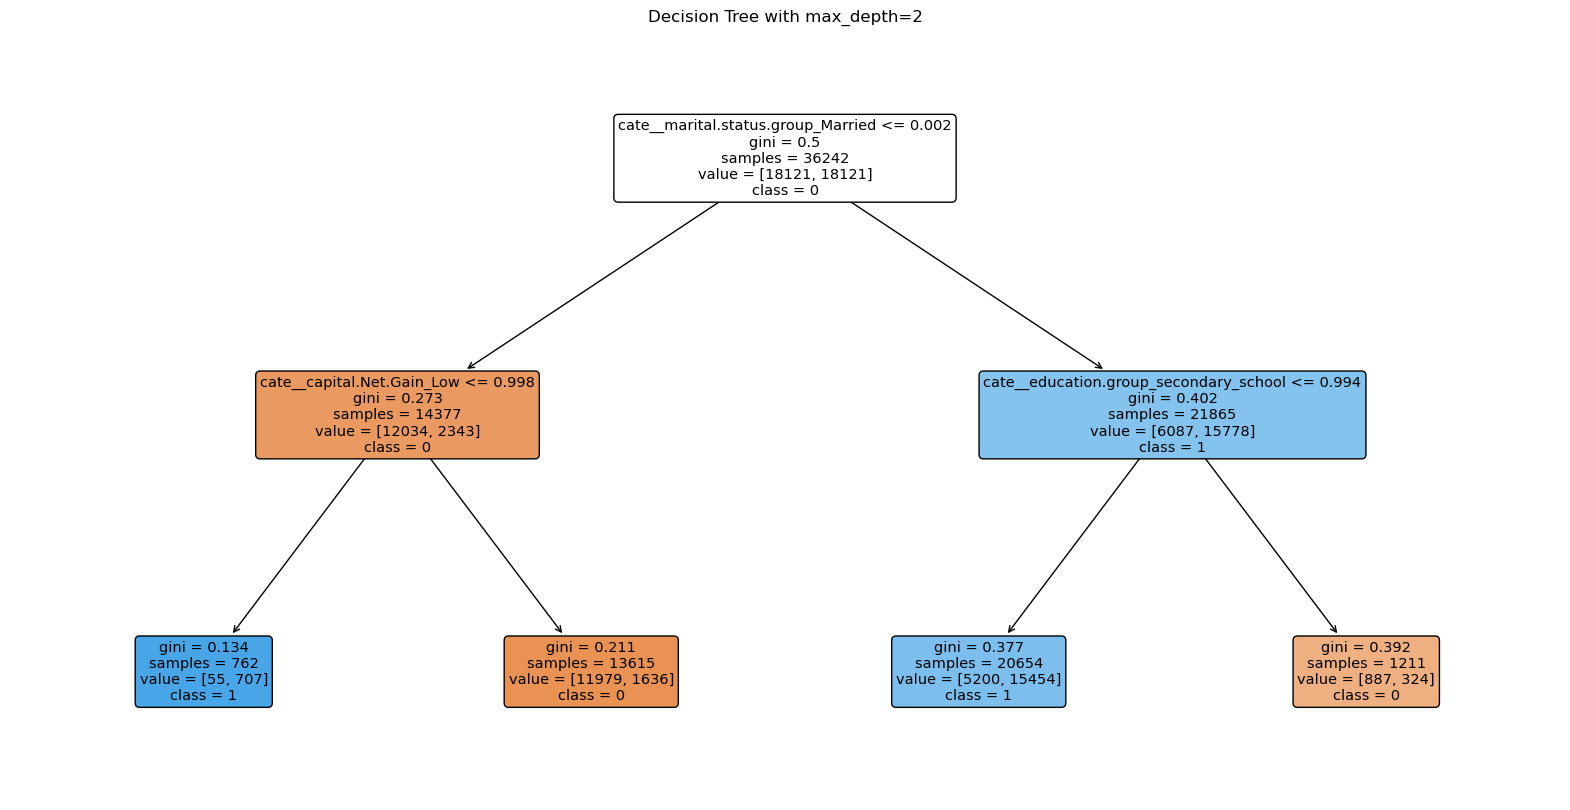



Decision Rules with max_depth=3:

|--- cate__marital.status.group_Married <= 0.00
|   |--- cate__capital.Net.Gain_Low <= 1.00
|   |   |--- cate__relationship_Not-in-family <= 0.00
|   |   |   |--- class: 1
|   |   |--- cate__relationship_Not-in-family >  0.00
|   |   |   |--- class: 1
|   |--- cate__capital.Net.Gain_Low >  1.00
|   |   |--- num__hours.per.week <= 0.40
|   |   |   |--- class: 0
|   |   |--- num__hours.per.week >  0.40
|   |   |   |--- class: 0
|--- cate__marital.status.group_Married >  0.00
|   |--- cate__education.group_secondary_school <= 0.99
|   |   |--- cate__education.group_HS-grad <= 1.00
|   |   |   |--- class: 1
|   |   |--- cate__education.group_HS-grad >  1.00
|   |   |   |--- class: 1
|   |--- cate__education.group_secondary_school >  0.99
|   |   |--- cate__capital.Net.Gain_Low <= 0.99
|   |   |   |--- class: 1
|   |   |--- cate__capital.Net.Gain_Low >  0.99
|   |   |   |--- class: 0



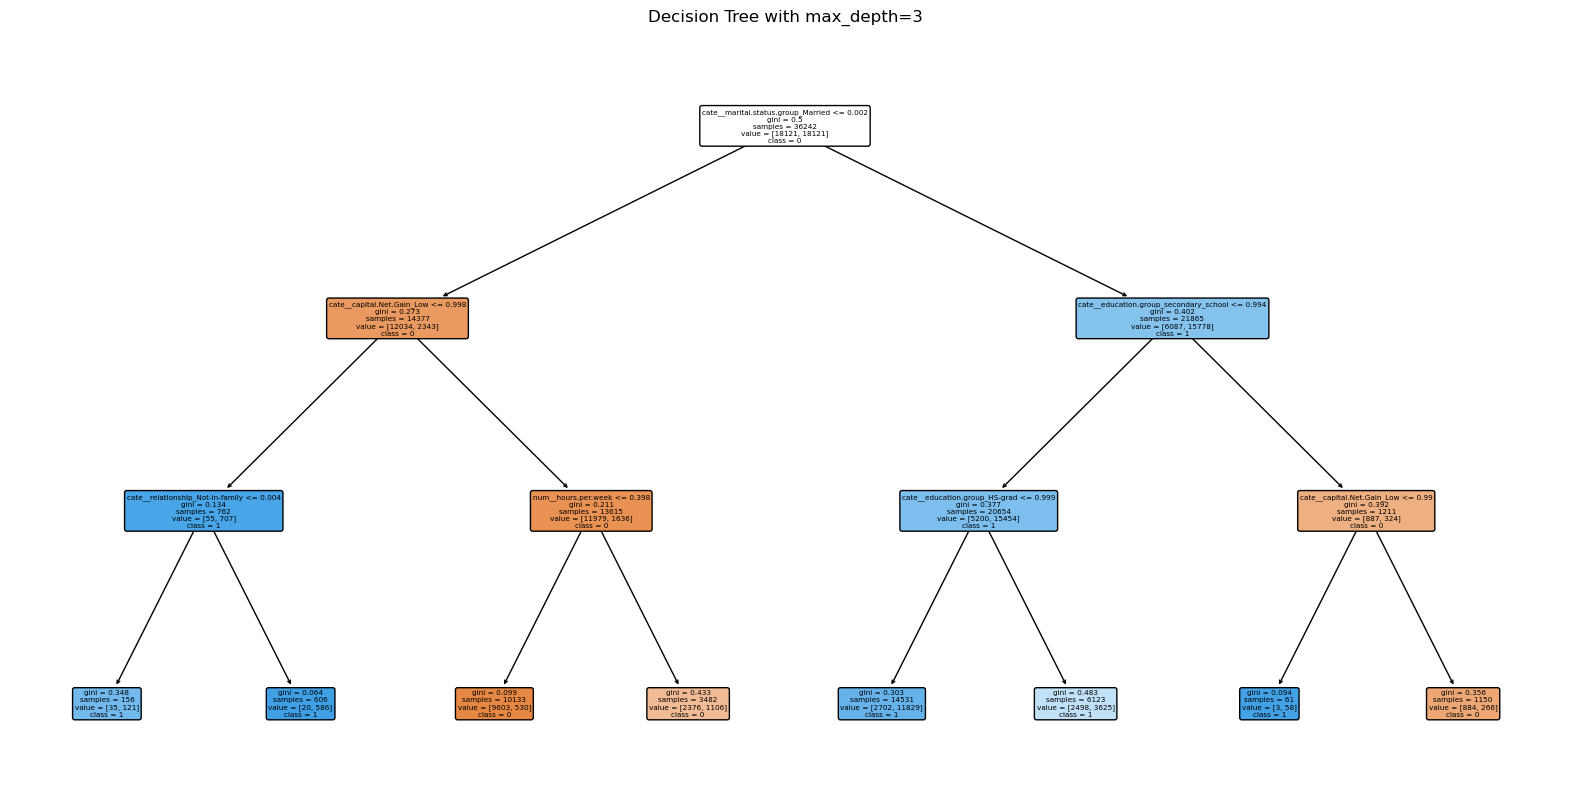



Decision Rules with max_depth=4:

|--- cate__marital.status.group_Married <= 0.00
|   |--- cate__capital.Net.Gain_Low <= 1.00
|   |   |--- cate__relationship_Not-in-family <= 0.00
|   |   |   |--- cate__capital.Net.Gain_Low <= 0.00
|   |   |   |   |--- class: 1
|   |   |   |--- cate__capital.Net.Gain_Low >  0.00
|   |   |   |   |--- class: 1
|   |   |--- cate__relationship_Not-in-family >  0.00
|   |   |   |--- num__hours.per.week <= 0.60
|   |   |   |   |--- class: 1
|   |   |   |--- num__hours.per.week >  0.60
|   |   |   |   |--- class: 1
|   |--- cate__capital.Net.Gain_Low >  1.00
|   |   |--- num__hours.per.week <= 0.40
|   |   |   |--- cate__occupation_Prof-specialty <= 0.03
|   |   |   |   |--- class: 0
|   |   |   |--- cate__occupation_Prof-specialty >  0.03
|   |   |   |   |--- class: 0
|   |   |--- num__hours.per.week >  0.40
|   |   |   |--- cate__education.group_HS-grad <= 1.00
|   |   |   |   |--- class: 0
|   |   |   |--- cate__education.group_HS-grad >  1.00
|   |   | 

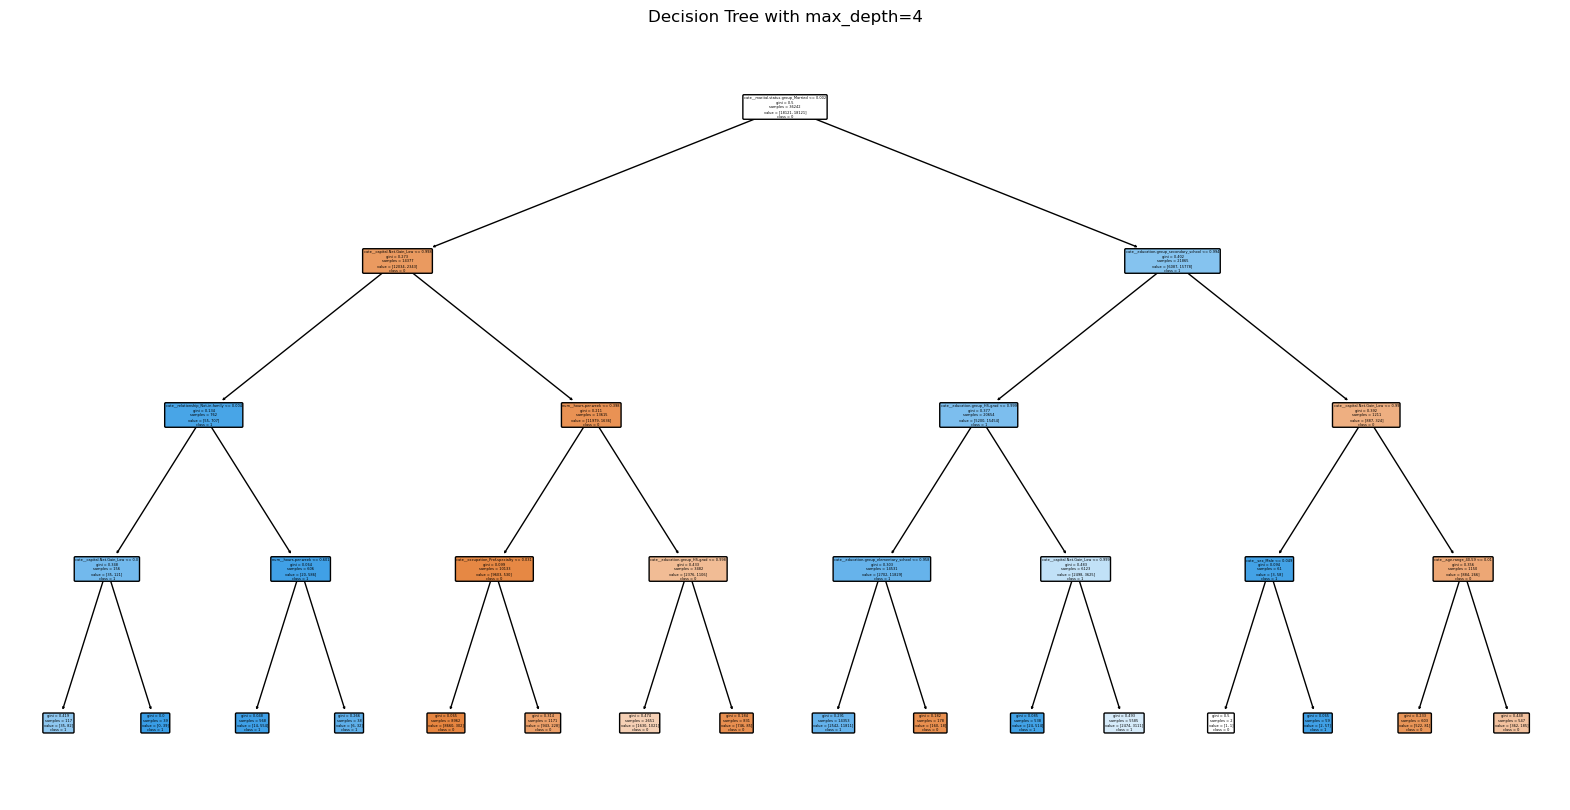



Decision Rules with max_depth=5:

|--- cate__marital.status.group_Married <= 0.00
|   |--- cate__capital.Net.Gain_Low <= 1.00
|   |   |--- cate__relationship_Not-in-family <= 0.00
|   |   |   |--- cate__capital.Net.Gain_Low <= 0.00
|   |   |   |   |--- cate__occupation_Other-service <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- cate__occupation_Other-service >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- cate__capital.Net.Gain_Low >  0.00
|   |   |   |   |--- class: 1
|   |   |--- cate__relationship_Not-in-family >  0.00
|   |   |   |--- num__hours.per.week <= 0.60
|   |   |   |   |--- cate__education.group_HS-grad <= 0.96
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- cate__education.group_HS-grad >  0.96
|   |   |   |   |   |--- class: 1
|   |   |   |--- num__hours.per.week >  0.60
|   |   |   |   |--- cate__education.group_Bachelors <= 0.94
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- cate__education.group_Bachelors >  0.94
|   |   | 

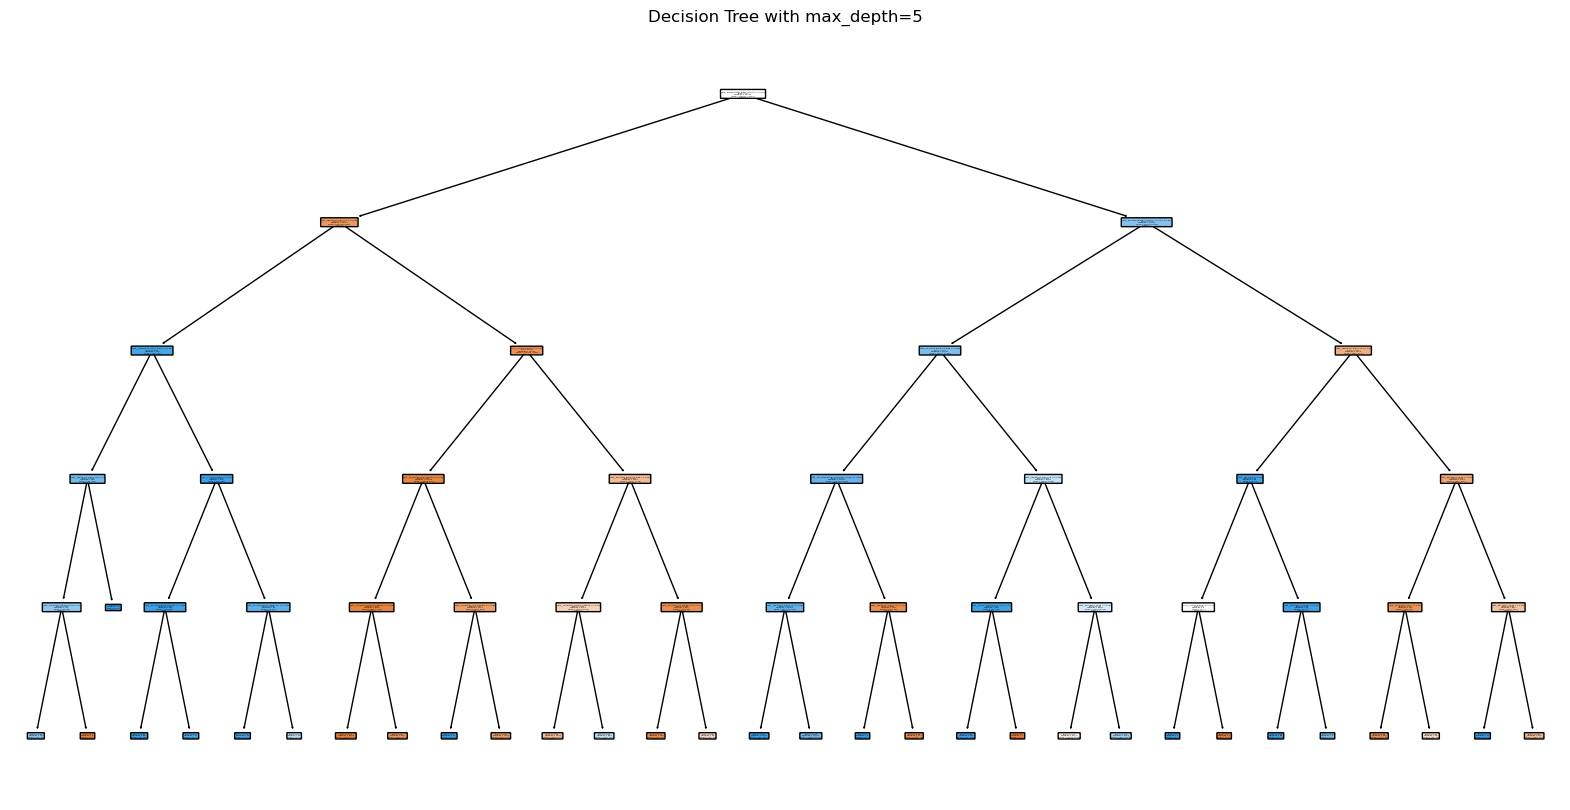



Decision Rules with max_depth=6:

|--- cate__marital.status.group_Married <= 0.00
|   |--- cate__capital.Net.Gain_Low <= 1.00
|   |   |--- cate__relationship_Not-in-family <= 0.00
|   |   |   |--- cate__capital.Net.Gain_Low <= 0.00
|   |   |   |   |--- cate__occupation_Other-service <= 0.50
|   |   |   |   |   |--- cate__workclass_Self-emp-not-inc <= 0.19
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- cate__workclass_Self-emp-not-inc >  0.19
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- cate__occupation_Other-service >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- cate__capital.Net.Gain_Low >  0.00
|   |   |   |   |--- class: 1
|   |   |--- cate__relationship_Not-in-family >  0.00
|   |   |   |--- num__hours.per.week <= 0.60
|   |   |   |   |--- cate__education.group_HS-grad <= 0.96
|   |   |   |   |   |--- cate__native.country.group_England <= 0.99
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- cate__native.country.group_Englan

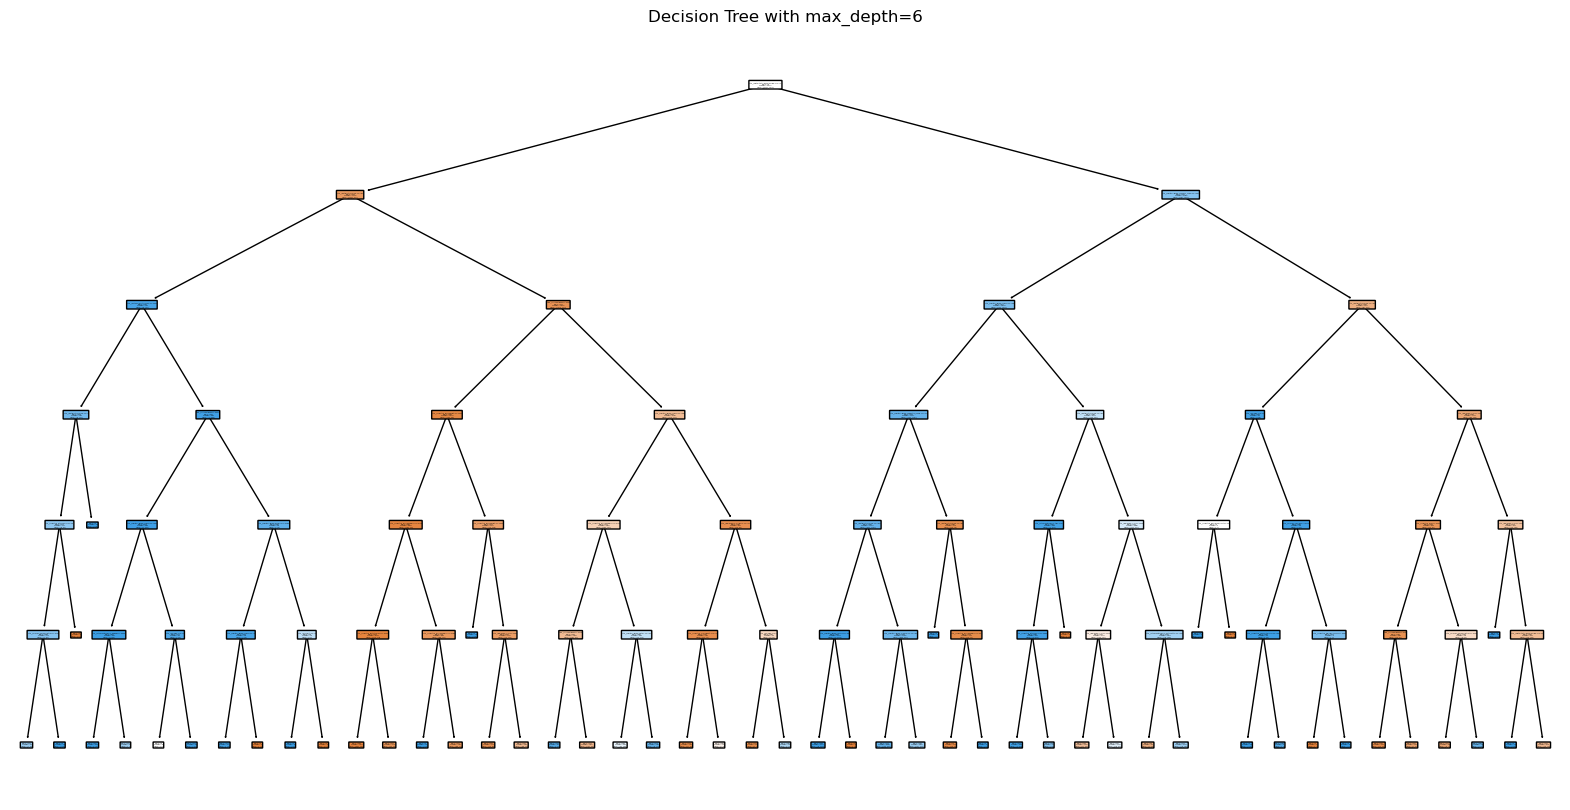

In [65]:
#### Iterative code to change the max_depth of DT and get the rules
feature_names = list(feature_names)  # Convert to list if it's an array

# Convert the NumPy array to DataFrame
X_train_smote_df = pd.DataFrame(X_train_smote, columns=feature_names)

# Define class names
class_names = ['0', '1']  # 0 for <=50K, 1 for >50K

# Define a list of max_depth values to try
depths = [2, 3, 4, 5, 6]  # Adjust based on what is readable

for depth in depths:
    # Initialize and train the Decision Tree model with the current max_depth
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_model.fit(X_train_smote_df, y_train_smote)
    
    # Print the decision rules
    print(f"Decision Rules with max_depth={depth}:\n")
    decision_rules = export_text(dt_model, feature_names=feature_names)
    print(decision_rules)
    
    # Plot the Decision Tree
    plt.figure(figsize=(20, 10))
    plot_tree(dt_model, feature_names=feature_names, class_names=class_names, filled=True, rounded=True)
    plt.title(f"Decision Tree with max_depth={depth}")
    plt.show()
    
    # Separator between depths for clarity
    print("\n" + "="*50 + "\n")

### Combining DT and RF

DT and RF are combined to extract decision rules thar provides conciseness, support, reliability, peculiarity, diversity, novelty, surprisingness, utility and actionability. Using Decision Trees DT and RF in conjunction with tree plots can provide both visual insights and validation of rules. Using both algorithms is achieved by training and evaluating a Decision Tree by experimenting with different max_depth values to determine the optimal depth and extract its decision rules. Additionally, fit a Random Forest model on the same dataset to assess feature importance and understand the contribution of each feature. This approach helps in visualizing, comparing, and validating the decision-making processes of both DT and RF models

This code will evaluate both models, print out the decision rules and performance metrics, and provide insights into feature importances for the Random Forest model

In [66]:
# Convert the NumPy array to DataFrame for training
X_train_smote_df = pd.DataFrame(X_train_smote, columns=feature_names)

# Convert the NumPy array to DataFrame for testing
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Ensure feature_names are the same shown in X_train_smote_df
feature_names = X_train_smote_df.columns.tolist()

# Define class names
class_names = ['0', '1']  # 0 for <=50K, 1 for >50K

# Define a list of max_depth values to try for the Decision Tree
depths = [2, 3, 4, 5, 6]  # Adjust based on what is readable

# Initialize lists to store results
decision_tree_results = []
random_forest_results = []

# Loop through different depths for Decision Tree
for depth in depths:
    # Initialize and train the Decision Tree model
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_model.fit(X_train_smote_df, y_train_smote)
    
   
    # Evaluate Decision Tree performance
    y_pred_dt = dt_model.predict(X_test_transformed_df)
    dt_report = classification_report(y_test, y_pred_dt, target_names=class_names)
    decision_tree_results.append((depth, dt_report))

# Train and evaluate the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote_df, y_train_smote)

# Predict and evaluate Random Forest performance
y_pred_rf = rf_model.predict(X_test_transformed_df)
rf_report = classification_report(y_test, y_pred_rf, target_names=class_names)
random_forest_results.append(rf_report)

# Print Random Forest feature importances
print("Random Forest Feature Importances:")
importances = rf_model.feature_importances_
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")

# Print Decision Tree results
print("\nDecision Tree Results:")
for depth, report in decision_tree_results:
    print(f"max_depth={depth}")
    print(report)

# Print Random Forest results
print("\nRandom Forest Results:")
print(rf_report)


Random Forest Feature Importances:
num__hours.per.week: 0.1669
cate__age.range_30-39: 0.0206
cate__age.range_40-59: 0.0351
cate__age.range_60 and above: 0.0101
cate__age.range_nan: 0.0001
cate__workclass_Local-gov: 0.0083
cate__workclass_Private: 0.0174
cate__workclass_Self-emp-inc: 0.0073
cate__workclass_Self-emp-not-inc: 0.0109
cate__workclass_State-gov: 0.0073
cate__workclass_Without-pay: 0.0001
cate__education.group_Bachelors: 0.0252
cate__education.group_Doctorate: 0.0053
cate__education.group_HS-grad: 0.0219
cate__education.group_Masters: 0.0149
cate__education.group_Preschool: 0.0002
cate__education.group_Prof-school: 0.0067
cate__education.group_Some-college: 0.0141
cate__education.group_elementary_school: 0.0036
cate__education.group_secondary_school: 0.0250
cate__marital.status.group_Married: 0.1422
cate__marital.status.group_NotMarried: 0.0758
cate__marital.status.group_Separated: 0.0059
cate__marital.status.group_Widowed: 0.0038
cate__occupation_Armed-Forces: 0.0000
cate__o

For DT max_depth=6, the following interesting rules are obtained based on married statuts, capital gains, relationship,occupation, hours.per.week, education,race, sex and native.country.
For people who are not married and have low capital net gain, their income classification depends largely on their family situation and occupation. If their occupation is "Self-emp-not-inc," they are more likely to be classified as class 1: earning over $50K, while if their occupation is "Other-service," they are more likely to be classified class 0: earning 50K or less.
For those with higher capital net gain, the number of hours they work and their level of education become more important. For example, if they work fewer hours and have a high school diploma, their income might be classified as higher if they are from England. However, if they work more hours and have a bachelor's degree, their income classification can vary depending on their race or gender.
For married individuals, education level and capital net gain are crucial. Those with lower education (like "elementary_school") or lower capital net gain might have varied income classifications depending on their occupation or country of origin. High capital net gain combined with some college education generally points to a higher income.


Now, these rules extracted from DT are compared with the feature importance from the RF model. The goal is to see if these DT rules align with the overall feature importance as determined by RF. For example, if a feature heavily influences the DT rules, it should also have a high importance score in the RF model. As stated before, this comparison helps validate if the rules derived from DT are consistent with what RF considers important. The DT rules extracted from max-depth=6 and the below RF feature importance are compared.
The DT is split by using married stats as the feature with highest information gain., the capital gain, occupation, hours per week, education age sex and native country. The importance scores from RT aligns with DT rules with the high importance of hours per week (0.169), marital status (0.1422), education (bachelor 0.0252, secondary school 0.0250), occupation (exce-,managerial 0.027) and age group (40-50 0.0351)

 It is observed that the DT rules with a maximum depth of 6 indicate how different features impact the income classification. If marital status is "Married," and capital gain is low, the model checks the relationship status and other features like occupation and workclass to decide the income class. For example, if someone is married, has a low capital gain, and works in certain occupations, they might be classified as earning more than $50K. If marital status isn't "Married," the model looks at other factors like hours worked per week and education level to determine income. Random Forest feature importance show that the most influential factors are hours worked per week, marital status, and education level.

This alignment suggests that DT rules are effectively capturing the influence of important features, and the RF model confirms these features' significance.

### Desicion rules

The following examples demonstrate how to assess different aspects of rules derived from a Decision Tree model, showing their practical implications and insights

#### Conciseness


Conciseness refers to the simplicity and brevity of the decision rules. With a lower max_depth, the rules are more straightforward and easier to understand

In [67]:
# Example DataFrame
df = pd.DataFrame({
    'education.group': ['HS-grad', 'secondary_school', 'Some-college', 'HS-grad', 'secondary_school'],
    'marital.status.group': ['Widowed', 'Divorced', 'Separated', 'Divorced', 'Separated'],
    'capital.Net.Gain': ['Low', 'High', 'Low', 'Low', 'Low'],
    'income': ['<=50K', '<=50K', '>50K', '<=50K', '<=50K']
})

# Define the rule
rule_df = df[
    (df['education.group'] == 'secondary_school') &
    (df['capital.Net.Gain'] == 'Low') &
    (df['marital.status.group'] == 'Separated') &
    (df['income'] == '<=50K')
]

# Check how many records meet the rule
print(rule_df)

    education.group marital.status.group capital.Net.Gain income
4  secondary_school            Separated              Low  <=50K


In [68]:
# Example DataFrame
df = pd.DataFrame({
    'education.group': ['HS-grad', 'secondary_school', 'Some-college', 'HS-grad', 'secondary_school', 'Bachelors', 'Bachelors'],
    'marital.status.group': ['Widowed', 'Divorced', 'Separated', 'Divorced', 'Separated', 'Married', 'Married'],
    'capital.Net.Gain': ['Low', 'High', 'Low', 'Low', 'High', 'High', 'High'],
    'income': ['<=50K', '<=50K', '>50K', '<=50K', '<=50K', '>50K', '>50K']
})

# Define the rule
rule = df[
    (df['education.group'] == 'Bachelors') &
    (df['capital.Net.Gain'] == 'High') &
    (df['marital.status.group'] == 'Married') &
    (df['income'] == '>50K')
]

# Print the records meeting the rule
print("Records meeting the rule:")
print(rule)

Records meeting the rule:
  education.group marital.status.group capital.Net.Gain income
5       Bachelors              Married             High   >50K
6       Bachelors              Married             High   >50K


In general, the results indicate that individuals with higher education levels, such as those holding a Bachelors degree, and those with High capital gains, tend to have higher incomes, as seen in the rule where both conditions were met and led to a higher-income classification. Conversely, individuals with secondary_school education, Low capital gain, and Separated marital status are associated with lower income levels, reflecting a trend where lower education and financial factors correlate with reduced income. This suggests that higher education and capital gains are strongly associated with higher income, while lower education and capital gains, combined with certain marital statuses, tend to be associated with lower income.

#### Coverage

Coverage indicates the proportion of instances in the dataset that are covered by a rule. This rule covers calculates the proportion of each income level within each education group by dividing the counts of each income level by the total count of the respective education group

In [69]:
# Calculate the total count for each education group
education_counts_2 = df_2['education.group'].value_counts()

# Calculate the count of each income level within each education group
income_counts_2 = df_2.groupby('education.group')['income'].value_counts().unstack().fillna(0)

# Calculate the coverage for each income level within each education group
coverage_2 = income_counts_2.div(education_counts_2, axis=0) * 100

print("Coverage for df_2:")
print(coverage_2)

Coverage for df_2:
income                 0     1
education.group               
Assoc              74.08 25.92
Bachelors          57.85 42.15
Doctorate          25.33 74.67
HS-grad            83.57 16.43
Masters            43.58 56.42
Preschool         100.00  0.00
Prof-school        25.09 74.91
Some-college       79.99 20.01
elementary_school  95.90  4.10
secondary_school   93.64  6.36


Higher Education (like Doctorate, Master’s, and Professional School) generally has a higher percentage of people earning >50K compared to lower levels of education.
Lower Education (like Preschool, Elementary School, and High School) generally has a higher percentage of people earning <=50K.

#### Reliability

Reliability refers to the consistency of a rule across different subsets of the data. A reliable rule is one that consistently holds true in various situations. The train dataset in the Decision Tree model can be assessed on different subsets of data using cross-validation to assess reliability and check if the rule’s predictions are consistent. A high mean cross-validation score suggests that the model and its rules are stable and dependable.

In [70]:
# Define the Decision Tree model
DT_model_CV = DecisionTreeClassifier(max_depth=3, random_state=42)

# Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(DT_model_CV, X_train_smote_df, y_train_smote, cv=kf)

# Print cross-validation scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.4f}")

Cross-validation scores: [0.79776521 0.80728376 0.80173841 0.79759934 0.80725717]
Mean cross-validation score: 0.8023


The model accuracy is fairly consistent across the folds, with scores ranging from approximately 0.798 to 0.807. This consistency is a good sign that your model is stable and not overly sensitive to the specific data splits. The mean cross-validation score of 0.8023 indicates that, on average, the DT model correctly classifies about 80.23% of the instances

#### Confidence

Confidence measures how often a rule correctly predicts the target variable. It meeasured the proportion of correct predictions made by a rule compared to all instances where the rule applies

In [71]:
# Define and train the Decision Tree model
DT_model_confide = DecisionTreeClassifier(max_depth=3, random_state=42)
DT_model_confide .fit(X_train_smote_df, y_train_smote)

# Make predictions
y_pred_train_DT_confi = DT_model_confide.predict(X_train_smote_df)

# Calculate accuracy
accuracy = accuracy_score(y_train_smote, y_pred_train_DT_confi)
print(f"Accuracy on training set: {accuracy:.4f}")


Accuracy on training set: 0.8024


The training set matches the mean cross-validation score which is shows a consistent model’s performance

#### Preculiarity

Peculiarity refers to how unique or specific a rule is, often implying that it applies to a small, distinct subset of the data. This rule is peculiar because it targets a specific combination of native.country and occupation, which may only apply to a small subset of the data.

In [72]:
# Define the rule
rule_subset = X_train_smote_df[(X_train_smote_df['cate__native.country.group_United-States'] == 1) &
                               (X_train_smote_df['cate__occupation_Tech-support'] == 1)]

# Count the number of records matching the rule
num_records = rule_subset.shape[0]
print(f"Number of records matching the rule: {num_records}")

# Total number of records in the dataset
total_records = X_train_smote_df.shape[0]
print(f"Total number of records in the dataset: {total_records}")

# Calculate the peculiarity percentage
peculiarity_percentage = (num_records / total_records) * 100
print(f"Peculiarity percentage: {peculiarity_percentage:.2f}%")

Number of records matching the rule: 999
Total number of records in the dataset: 36242
Peculiarity percentage: 2.76%


The peculiarity percentage of 2.76% shows that the rule about having United States as the native country and Tech-support as the occupation applies to 2.76% of the records in your dataset. This combination is not very common but still makes up a noticeable part of your data.

#### Surprisingness

Surprisingness indicates how counterintuitive or unexpected a rule is. For example, if the rule shows that older people who work fewer hours tend to earn less, it might be surprising because we might expect older people to earn more, especially if they have more experience


In [74]:
# Merge features and target into one DataFrame
y_train_smote_df = pd.DataFrame(y_train_smote, columns=['income'])

train_smote_df = pd.concat([X_train_smote_df, y_train_smote_df], axis=1)

# Rule 1: Individuals from the U.S. in Tech-support
rule1 = (train_smote_df['cate__native.country.group_United-States'] == 1) & \
        (train_smote_df['cate__occupation_Tech-support'] == 1)

# Rule 2: Older individuals (60+) working fewer hours (<=40)
rule2 = (train_smote_df['num__hours.per.week'] <= 40) & \
        (train_smote_df['cate__age.range_60 and above'] == 1)

# Function to calculate income distribution for a rule
def calculate_income_distribution(df, rule):
    subset = df[rule]
    return subset['income'].value_counts(normalize=True) * 100

# Calculate and print income distribution
def print_income_distributions(df, rule, rule_name):
    income_rule = calculate_income_distribution(df, rule)
    income_total = df['income'].value_counts(normalize=True) * 100
    diff = income_rule - income_total
    print(f"Income distribution for {rule_name}: \n{income_rule}")
    print(f"Total income distribution: \n{income_total}")
    print(f"Difference: \n{diff}\n")

# Print distributions for both rules
print_income_distributions(train_smote_df, rule1, "Rule 1: U.S. Tech-support")
print_income_distributions(train_smote_df, rule2, "Rule 2: 60+ & <=40 hours")

Income distribution for Rule 1: U.S. Tech-support: 
income
1   54.15
0   45.85
Name: proportion, dtype: float64
Total income distribution: 
income
0   50.00
1   50.00
Name: proportion, dtype: float64
Difference: 
income
0   -4.15
1    4.15
Name: proportion, dtype: float64

Income distribution for Rule 2: 60+ & <=40 hours: 
income
0   51.16
1   48.84
Name: proportion, dtype: float64
Total income distribution: 
income
0   50.00
1   50.00
Name: proportion, dtype: float64
Difference: 
income
0    1.16
1   -1.16
Name: proportion, dtype: float64



## 5. Conclusions

In this project, the 1994 Census Income dataset is analysed to uncover factors influencing whether a person earns more than $50K annually. DT and RF models, decision rules are extracted decision rules that provide clear, interpretable insights into the income classification process. The DT rules revealed that marital status, capital gains, and education levels are significant factors in determining income. These rules were validated by comparing them with RF feature importance, which highlighted similar key features, confirming the consistency of our findings.

The results showed that different DT depths provided varying levels of detail, with a depth of 4 offering a good balance between accuracy and simplicity. The RF model supported this by emphasizing the importance of hours worked per week, marital status, and education level. Overall, the combination of DT and RF methods allowed us to effectively understand and validate the factors influencing income, with the recommendation to use a maximum depth of 4 for Decision Trees to avoid overfitting while maintaining robust predictive performance.


## 6. Sources

1.	https://medium.com/analytics-vidhya/adult-census-income-dataset-using-multiple-machine-learning-models-f289c960005d
2.	https://medium.com/geekculture/generate-synthetic-dataset-with-the-synthetic-data-vault-sdv-26b564b8fe15
3.	https://towardsdatascience.com/a-review-of-synthetic-tabular-data-tools-and-models-d83b232aae25
4.	https://www.geeksforgeeks.org/wine-dataset/
5.	https://allysonf.medium.com/predict-red-wine-quality-with-svc-decision-tree-and-random-forest-24f83b5f3408
6.	https://colab.research.google.com/github/rasbt/machine-learning-book/blob/main/ch04/ch04.ipynb#scrollTo=q_VNSZzeOqtS
7.	https://medium.com/bitgrit-data-science-publication/10-best-practices-for-data-science-21a748a410e4
8.	https://www.shiksha.com/online-courses/articles/handle-imbalanced-data-in-a-classification-problem/
9.	https://towardsdatascience.com/working-with-highly-imbalanced-datasets-in-machine-learning-projects-c70c5f2a7b16
10.	https://www.whiteboxml.com/en/blog/the-definitive-guide-to-python-virtual-environments-with-conda
11.	https://towardsdatascience.com/how-to-set-up-anaconda-and-jupyter-notebook-the-right-way-de3b7623ea4a
12.	https://allysonf.medium.com/predict-red-wine-quality-with-svc-decision-tree-and-random-forest-24f83b5f3408
13.	https://github.com/Qudirah/ML_Case_Study
14.	https://github.com/rasbt/machine-learning-book/tree/main/ch05
15.	https://github.com/rasbt/machine-learning-book/tree/main/ch04
16.	https://github.com/rasbt/machine-learning-book/tree/main/ch06
17.	https://towardsdatascience.com/guide-to-classification-on-imbalanced-datasets-d6653aa5fa23
18.	https://github.com/Qudirah/ML_Case_Study
19.	https://medium.com/analytics-vidhya/adult-census-income-dataset-using-multiple-machine-learning-models-f289c960005d
20.	https://www.kaggle.com/code/fnurazman/adult-income-prediction-eda-logistic-knn-svm
21.	https://www.kaggle.com/code/denismunene/income-prediction-from-cencus-data-kagglex-bipoc
22.	https://www.kaggle.com/code/eskilie/adult-census-income-eda-ml
23.	https://www.kaggle.com/code/soumya044/adult-census-income-gdg
